# cuda:4

In [1]:
import sys
sys.path.insert(1,'/home/bwhiteak/ChaosESN/ESN_utils/')

import numpy as np
import torch
import rc_tools as rct
import rc_analysis as rca
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.optimize import fsolve
from scipy.signal import argrelextrema
import warnings
import time

import pdb

from skopt.space import Real,Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

import traceback
import warnings
warnings.filterwarnings("ignore")

from jupyterthemes import jtplot
jtplot.style()

np.random.seed(11)
torch.set_printoptions(precision=10)
dtype = torch.float32 

print(f'Python: {sys.version}')
print(f'Numpy: {np.__version__}')
print(f'Torch: {torch.__version__}')

DEVICE = 'cuda:4'

FREERUN = 20
DT = .02

rho = 28.0
sigma = 10.0
beta = 8/3

def f(state, t):
    x,y,z = state
    return sigma*(y-x), x*(rho-z)-y, x*y - beta*z

state0 = [1.,1.,1.]
t = np.arange(0,300+FREERUN,DT)
states = odeint(f,state0,t)

muX = np.mean(states[:,0])
signal = states[:,0]-muX

M = signal.shape[0] - int(FREERUN/DT)
K = 1
L = 1
RF = .5
TEST = 1000
LEAD = 100
BURNIN = 100
REG = 1e-8
TRAINLENGTH = M-TEST


MINMAX = np.max(signal[:TRAINLENGTH+TEST]) - np.min(signal[:TRAINLENGTH+TEST])
STD = np.std(signal[:TRAINLENGTH+TEST])
BINS = 50

print(f'Signal length M={M}')
print(f'Normalizing value max-min id {MINMAX:.3f}')
print(f'Normalizing value std id {STD:.3f}')

Python: 3.8.12 (default, Oct 12 2021, 13:49:34) 
[GCC 7.5.0]
Numpy: 1.21.2
Torch: 1.10.0
Signal length M=15000
Normalizing value max-min id 38.053
Normalizing value std id 7.912


In [2]:
def get_weight_matricesGPU(k,n,l,ri,ro):
    win = torch.rand((n,k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ri)
    wfb = torch.zeros((n,l),dtype=dtype, device=torch.device(DEVICE))
    wout = torch.rand((l,n+k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ro)
    return win, wfb, wout

def set_vectorsGPU(n,l,r):
    x0 = torch.rand((n,1),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(r)
    y0 = torch.zeros((l,1),dtype=dtype, device=torch.device(DEVICE))
    return x0, y0

def update_res_stateGPU(wnet,xt,uxy,a,g):
    z = torch.matmul(wnet,uxy)
    return torch.mul(xt,1-a) + torch.mul(torch.tanh(z),a*g)

def predict_yGPU(wout,xu):
    return torch.matmul(wout, xu)

def get_matrixGPU(n,r,sr):
    A = (torch.rand((n,n),dtype=dtype,
                   device=torch.device(DEVICE))-.5)*r
    At = torch.transpose(A,0,1)
    D = torch.diag(torch.diag(A))   
    W = A + At - D
    eig = torch.eig(W, eigenvectors=False)
    wsr = torch.max(torch.abs(eig[0]))
    return W.div(wsr).mul(sr)

def resize_spaces(mn, mx, best, isAlpha=False):
    #pdb.set_trace()
    if(best.size==0):
        new_mn = np.max([0, mn - .5*mn])
        new_mx = 1.5*mx
    else:
        best_mn = np.min(best)
        best_mx = np.max(best)
        mn_bound = (best_mn-mn)/2
        mx_bound = (mx -best_mx)/2
        new_mn, new_mx = best_mn-mn_bound, best_mx+mx_bound
        print(f'\nBest mn:{best_mn:.3f}\t mn:{best_mx:.3f}')
        print(f'New bounds mn--mx: {mn_bound:.3f}--{mx_bound:.3f}')
    if(isAlpha):
        if(new_mx>1):
            new_mx = 1
    
    return new_mn, new_mx

In [3]:
import json
from json import JSONEncoder

# numpy arrays cannot be written to json 
# convert to list
class NumpyArrayEncoder(JSONEncoder):
    def default(self,obj):
        if isinstance(obj,np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self,obj)

In [4]:
#min_a, max_a = .25, .4
#min_sr, max_sr = 1.25, 1.45
#min_ri, max_ri = .001, 4.
#min_rr, max_rr = .001, 4.

#min_a, max_a = .55, .85
#min_sr, max_sr = 1.2, 1.5
#min_g, max_g = .4, 1.1
#min_ri, max_ri = .001, .15
#min_rr, max_rr = 1.5, 2.3

min_a, max_a = .5, .9
min_sr, max_sr = 1., 1.5
min_g, max_g = .4, 1.1
min_ri, max_ri = .001, .3
min_rr, max_rr = 1, 3

space = [Real(min_a, max_a, name='a'),
         Real(min_sr, max_sr, name='sr'),
         Real(min_ri, max_ri, name='ri'),
         Real(min_rr, max_rr, name='rr')
        ]

@use_named_args(space)
def loop(a=1.0,sr=1.0,ri=1.0,rr=1.0):
    start = time.time()
    amp = 1.
    global running_error, s, counter, signal, N, \
           alphas, rhos, gammas, inScales, resScales, dict_model, \
           model_counter, error_per_N, error_over_N, best_N_model
    
    ut = torch.zeros((1,1),dtype=dtype,
                     device=torch.device(DEVICE))
    tp = torch.zeros((1,1),dtype=dtype,
                     device=torch.device(DEVICE))
    
    Wres = get_matrixGPU(N,rr,sr)
    Win, Wfb, Wout = get_weight_matricesGPU(K,N,L,ri,RF)
    Wnet = torch.cat((Win,Wres,Wfb),1)
    xt, yt = set_vectorsGPU(N,L,rr)

    states = torch.zeros((TRAINLENGTH, N+K),dtype=dtype,
                          device=DEVICE)
    targets = torch.zeros((TRAINLENGTH),dtype=dtype,
                          device=DEVICE)
    for i in range(TRAINLENGTH):
        ut[0,0] = s[i]
        tp[0,0] = s[i+1]
        targets[i] = s[i+1]
        uxy = torch.cat((ut,xt,yt),0)
        xt1 = update_res_stateGPU(Wnet,xt,uxy,a,amp)
        xu = torch.transpose(torch.cat((xt1,ut),0),0,1).to(DEVICE)
        states[i,:] = xu[0,:]
        xt, yt = xt1, tp 

    state = states.detach().cpu().numpy()

    torch.cuda.synchronize()
    wout = rct.get_trained_weights(state[BURNIN:],
                                   signal[BURNIN+1:TRAINLENGTH+1],
                                   REG)
    Wout = torch.from_numpy(wout.reshape(L,N+K)).type(dtype).cuda(DEVICE)
    torch.cuda.synchronize()

    predictions = torch.zeros((M+int(FREERUN/DT),1),
                              dtype=dtype,
                              device=torch.device(DEVICE))

    xt, yt = set_vectorsGPU(N,L,rr)
    ut.fill_(0.0)
    for i in range(M+int(FREERUN/DT)):
        if(i < TRAINLENGTH):
            ut[0,0] = s[i]
        else:
            ut = yt
        uxy = torch.cat((ut,xt,yt),0)
        xt1 = update_res_stateGPU(Wnet,xt,uxy,a,amp)
        xu = torch.cat((xt1,ut),0)
        yt1 = predict_yGPU(Wout,xu)
        predictions[i] = yt1[0,0]
        xt, yt = xt1, yt1

    yHat_GPU = predictions.detach().cpu().numpy()
    
    nrmse = 1000.0
    try:
        nrmse = rca.NRMSE(signal[TRAINLENGTH:TRAINLENGTH+TEST],
                          yHat_GPU[TRAINLENGTH:TRAINLENGTH+TEST],
                          MINMAX) 
    except Exception as e:
        pass #traceback.print_exc()
        
    
    try:
        nrmse_std = rca.NRMSE(signal[TRAINLENGTH:TRAINLENGTH+TEST],
                          yHat_GPU[TRAINLENGTH:TRAINLENGTH+TEST],
                          STD) 
    except Exception as e:
        pass #traceback.print_exc()
    
    
    av = signal[TRAINLENGTH:TRAINLENGTH+TEST].reshape(TEST,1)
    bv = np.squeeze(yHat_GPU[TRAINLENGTH:TRAINLENGTH+TEST]).reshape(TEST,1)
    num = np.squeeze(np.dot(av.T,bv))
    den = np.linalg.norm(av)*np.linalg.norm(bv)
    cosine_similarity = num/den
    cosine_distance = 1 - cosine_similarity
    dist = cosine_distance
    
    loss = nrmse + dist
    if(np.isnan(loss) or (np.isinf(loss) or (loss > 1000.0))):
        loss = 1000
    
    if((loss < running_error) and (nrmse < .3)):
        print(f'Dist {dist:3f}')
        running_error = loss
        wnet = Wnet.detach().cpu().numpy()
        currentParams = np.array([a,sr,amp,ri,rr,loss])
        if(error_over_N > running_error):
            print('\n\nNew N best!!!!!!!!!!!!\n\n')
            error_over_N = running_error  #set the lowest error
            best_N_model = [N,ref,rn,counter]
            states_dict = {'States': state}
            with open(f'Dicts/States/states_L3D_{N}.json', 'w') as fp:
                json.dump(states_dict, fp, cls=NumpyArrayEncoder)
            dict_model[str(N)] = {'Wnet': wnet,
                                  'Wout': wout,
                                  'Preds': yHat_GPU,
                                  'Params': currentParams}
            print(best_N_model)
            
        alphas.append(a)
        rhos.append(sr)
        gammas.append(amp)
        inScales.append(ri)
        resScales.append(rr)
        
        fig = plt.figure(figsize=(10,8))
        ax1 = plt.subplot(111)
        ax1.plot(signal[TRAINLENGTH-LEAD:], label='Target')
        ax1.plot(yHat_GPU[TRAINLENGTH-LEAD:], label='GPU')
        ax1.axvline(LEAD,c='orange',linestyle='dashed')
        ax1.axvline(LEAD+TEST,c='r',linestyle='dashed')
        ax1.set_ylim(-25,25)
        ax1.legend()
        plt.show()
        plt.close()
        model_counter += 1
        error_per_N.append(nrmse)
        
        print(f' Iter={counter} a={a:.3f} sr={sr:.3f} amp={amp:.3f}',
              f' ri={ri:.3f} rr={rr:.3f} loss={loss:3f} nrmse={nrmse:3f} CD {dist:3f}')
    ####### Running info ##############################
    print(f'Iter: {counter} #### Time {(time.time()-start):.2f}',
          f' NRMSE {nrmse:.3f} CD {dist:.3f}')
    ###### Store this run #############################
    dict_counters[str(N)] = {'numModels': model_counter,
                             'meanError': np.mean(np.array(error_per_N),axis=0).tolist(),
                             'varError' : np.var(np.array(error_per_N),axis=0).tolist()}
    counter += 1
    return loss

********** Size 50 -- Run 0 ***********
Iter: 0 #### Time 7.79  NRMSE 12.769 CD 0.974
Iter: 1 #### Time 3.81  NRMSE 0.618 CD 1.032
Iter: 2 #### Time 3.79  NRMSE 0.438 CD 1.083
Iter: 3 #### Time 3.77  NRMSE 0.475 CD 1.033
Dist 0.844615


New N best!!!!!!!!!!!!


[50, 0, 0, 4]


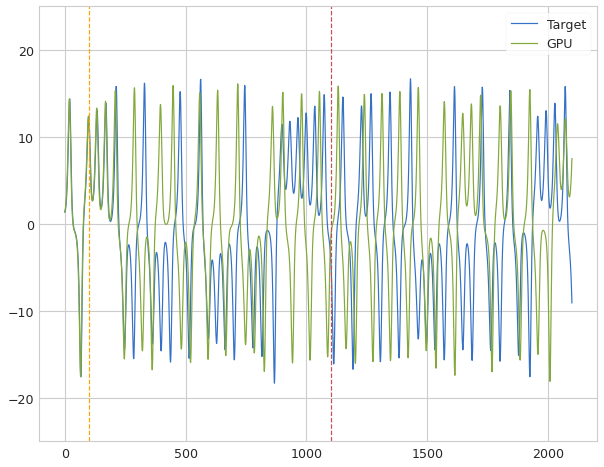

 Iter=4 a=0.888 sr=1.398 amp=1.000  ri=0.078 rr=2.025 loss=1.115108 nrmse=0.270493 CD 0.844615
Iter: 4 #### Time 4.96  NRMSE 0.270 CD 0.845
Iter: 5 #### Time 3.77  NRMSE 1000.000 CD nan
Iter: 6 #### Time 3.75  NRMSE 0.494 CD 0.949
Iter: 7 #### Time 3.79  NRMSE 1.568 CD 1.003
Iter: 8 #### Time 3.79  NRMSE 1.892 CD 0.988
Iter: 9 #### Time 3.77  NRMSE 3.051 CD 1.107
Iter: 10 #### Time 3.78  NRMSE 0.355 CD 1.074
Iter: 11 #### Time 3.78  NRMSE 1000.000 CD nan
Iter: 12 #### Time 3.74  NRMSE 0.290 CD 0.900
Iter: 13 #### Time 3.77  NRMSE 0.322 CD 1.064
Iter: 14 #### Time 3.75  NRMSE 1000.000 CD nan
Iter: 15 #### Time 3.74  NRMSE 0.521 CD 0.957
Iter: 16 #### Time 3.76  NRMSE 0.324 CD 1.054
Iter: 17 #### Time 3.75  NRMSE 1.110 CD 1.130
Iter: 18 #### Time 3.74  NRMSE 0.505 CD 1.065
Iter: 19 #### Time 3.76  NRMSE 0.289 CD 0.981
Iter: 20 #### Time 4.03  NRMSE 0.280 CD 0.917
Iter: 21 #### Time 4.01  NRMSE 0.380 CD 0.878
Iter: 22 #### Time 3.74  NRMSE 1000.000 CD nan
Iter: 23 #### Time 3.74  NRMSE 0.

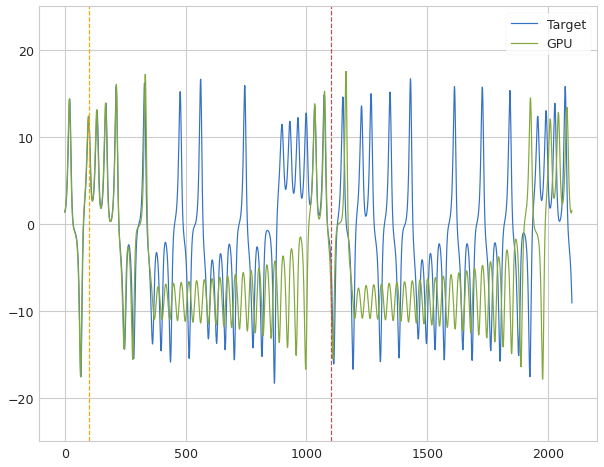

 Iter=24 a=0.543 sr=1.242 amp=1.000  ri=0.086 rr=2.711 loss=0.757950 nrmse=0.222218 CD 0.535732
Iter: 24 #### Time 5.06  NRMSE 0.222 CD 0.536
Iter: 25 #### Time 3.76  NRMSE 1000.000 CD nan
Iter: 26 #### Time 3.77  NRMSE 1000.000 CD nan
Iter: 27 #### Time 3.75  NRMSE 0.248 CD 0.732
Iter: 28 #### Time 3.77  NRMSE 1.694 CD 0.996
Iter: 29 #### Time 3.77  NRMSE 1000.000 CD nan
Iter: 30 #### Time 3.90  NRMSE 1000.000 CD nan
Iter: 31 #### Time 3.77  NRMSE 0.302 CD 0.838
Iter: 32 #### Time 3.78  NRMSE 0.288 CD 0.982
Iter: 33 #### Time 3.82  NRMSE 0.322 CD 1.061
Iter: 34 #### Time 3.76  NRMSE 1.107 CD 1.006
Iter: 35 #### Time 3.78  NRMSE 0.339 CD 1.016
Iter: 36 #### Time 3.78  NRMSE 1000.000 CD nan
Iter: 37 #### Time 3.79  NRMSE 0.302 CD 1.081
Iter: 38 #### Time 3.75  NRMSE 1000.000 CD nan
Iter: 39 #### Time 3.77  NRMSE 0.531 CD 1.075
Iter: 40 #### Time 3.76  NRMSE 1.772 CD 0.846
Iter: 41 #### Time 3.80  NRMSE 0.718 CD 1.036
Iter: 42 #### Time 3.77  NRMSE 0.347 CD 0.976
Iter: 43 #### Time 3.76 

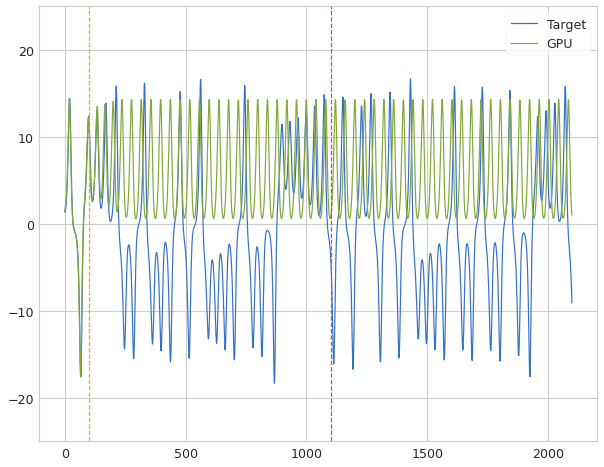

 Iter=2 a=0.552 sr=1.261 amp=1.000  ri=0.058 rr=2.578 loss=1.285274 nrmse=0.287356 CD 0.997918
Iter: 2 #### Time 4.08  NRMSE 0.287 CD 0.998
Iter: 3 #### Time 4.01  NRMSE 1000.000 CD nan
Iter: 4 #### Time 3.97  NRMSE 0.502 CD 1.027
Iter: 5 #### Time 3.95  NRMSE 1.217 CD 1.114
Iter: 6 #### Time 3.99  NRMSE 0.325 CD 1.074
Dist 0.512704


New N best!!!!!!!!!!!!


[50, 0, 1, 7]


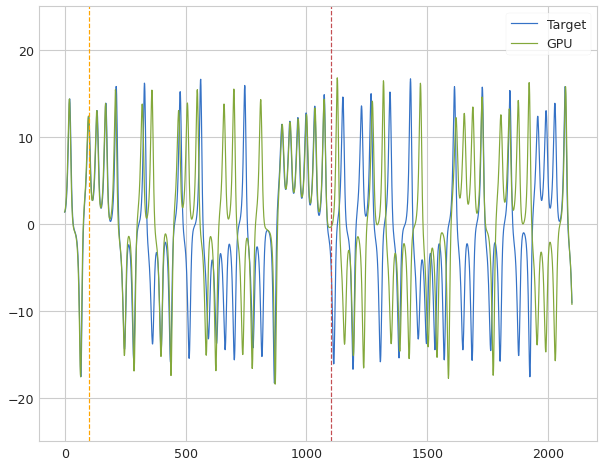

 Iter=7 a=0.764 sr=1.294 amp=1.000  ri=0.061 rr=2.582 loss=0.721345 nrmse=0.208640 CD 0.512704
Iter: 7 #### Time 5.15  NRMSE 0.209 CD 0.513
Iter: 8 #### Time 3.97  NRMSE 0.501 CD 0.973
Iter: 9 #### Time 3.96  NRMSE 0.287 CD 0.903
Iter: 10 #### Time 3.96  NRMSE 0.886 CD 0.996
Iter: 11 #### Time 3.96  NRMSE 3.096 CD 1.156
Iter: 12 #### Time 4.07  NRMSE 1000.000 CD nan
Iter: 13 #### Time 3.96  NRMSE 1000.000 CD nan
Iter: 14 #### Time 3.95  NRMSE 0.363 CD 0.923
Iter: 15 #### Time 3.96  NRMSE 0.314 CD 1.033
Iter: 16 #### Time 3.96  NRMSE 0.323 CD 0.904
Iter: 17 #### Time 3.95  NRMSE 0.305 CD 1.050
Iter: 18 #### Time 3.95  NRMSE 1000.000 CD nan
Iter: 19 #### Time 3.94  NRMSE 0.638 CD 1.045
Iter: 20 #### Time 3.94  NRMSE 1000.000 CD nan
Iter: 21 #### Time 3.95  NRMSE 1000.000 CD nan
Iter: 22 #### Time 3.87  NRMSE 0.918 CD 1.020
Iter: 23 #### Time 3.83  NRMSE 1000.000 CD nan
Iter: 24 #### Time 3.82  NRMSE 0.792 CD 1.036
Iter: 25 #### Time 3.82  NRMSE 0.379 CD 1.212
Iter: 26 #### Time 3.79  NRM

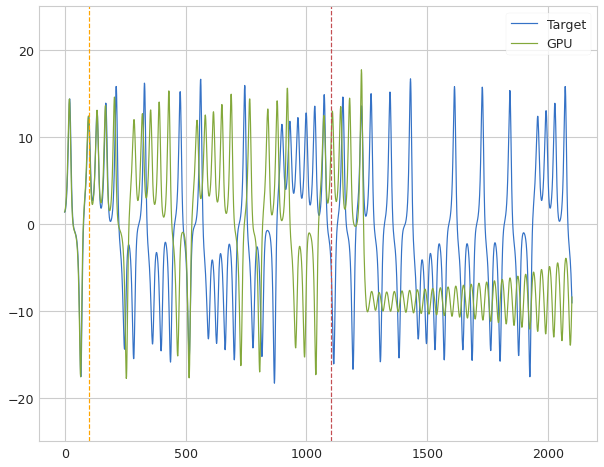

 Iter=14 a=0.706 sr=1.291 amp=1.000  ri=0.081 rr=2.316 loss=1.357830 nrmse=0.299211 CD 1.058619
Iter: 14 #### Time 5.42  NRMSE 0.299 CD 1.059
Iter: 15 #### Time 5.29  NRMSE 0.380 CD 0.945
Iter: 16 #### Time 5.25  NRMSE 1000.000 CD nan
Iter: 17 #### Time 5.25  NRMSE 0.314 CD 1.055
Iter: 18 #### Time 5.30  NRMSE 1000.000 CD nan
Iter: 19 #### Time 5.29  NRMSE 0.674 CD 0.970
Iter: 20 #### Time 5.26  NRMSE 1000.000 CD nan
Dist 0.820262


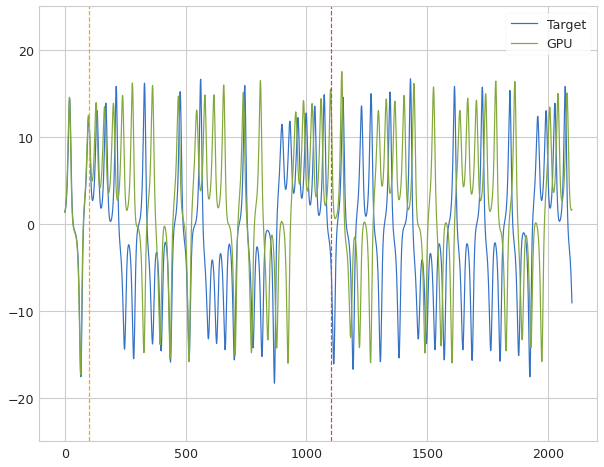

 Iter=21 a=0.632 sr=1.272 amp=1.000  ri=0.053 rr=2.425 loss=1.089699 nrmse=0.269437 CD 0.820262
Iter: 21 #### Time 5.41  NRMSE 0.269 CD 0.820
Iter: 22 #### Time 5.30  NRMSE 1.483 CD 0.998
Iter: 23 #### Time 5.26  NRMSE 0.383 CD 0.965
Dist 0.719631


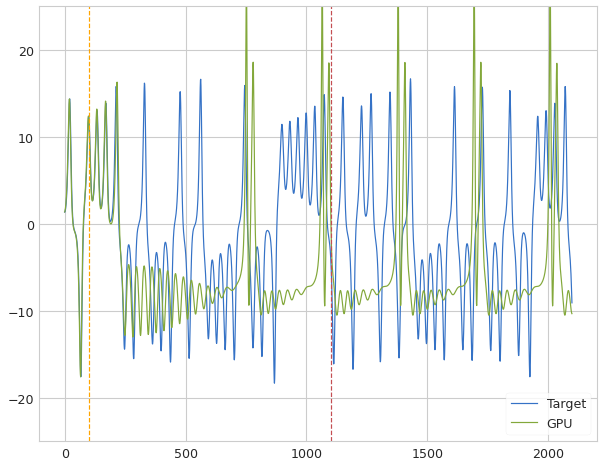

 Iter=24 a=0.613 sr=1.376 amp=1.000  ri=0.055 rr=2.828 loss=0.980078 nrmse=0.260447 CD 0.719631
Iter: 24 #### Time 5.38  NRMSE 0.260 CD 0.720
Iter: 25 #### Time 5.24  NRMSE 0.314 CD 1.063
Iter: 26 #### Time 5.25  NRMSE 0.289 CD 0.862
Iter: 27 #### Time 5.26  NRMSE 0.324 CD 0.878
Iter: 28 #### Time 5.26  NRMSE 0.318 CD 0.922
Iter: 29 #### Time 5.30  NRMSE 1000.000 CD nan
Iter: 30 #### Time 5.29  NRMSE 0.308 CD 1.058
Iter: 31 #### Time 5.28  NRMSE 0.474 CD 0.943
Iter: 32 #### Time 5.27  NRMSE 2.694 CD 0.847
Iter: 33 #### Time 5.26  NRMSE 15.676 CD 1.126
Iter: 34 #### Time 5.27  NRMSE 0.279 CD 0.935
Iter: 35 #### Time 5.26  NRMSE 1.158 CD 0.991
Iter: 36 #### Time 5.27  NRMSE 1000.000 CD nan
Iter: 37 #### Time 5.27  NRMSE 0.364 CD 1.015
Iter: 38 #### Time 5.29  NRMSE 1.492 CD 1.005
Iter: 39 #### Time 5.28  NRMSE 1000.000 CD nan
Iter: 40 #### Time 5.28  NRMSE 0.312 CD 1.055
Iter: 41 #### Time 5.27  NRMSE 1000.000 CD nan
Iter: 42 #### Time 5.25  NRMSE 0.288 CD 0.970
Iter: 43 #### Time 5.26  

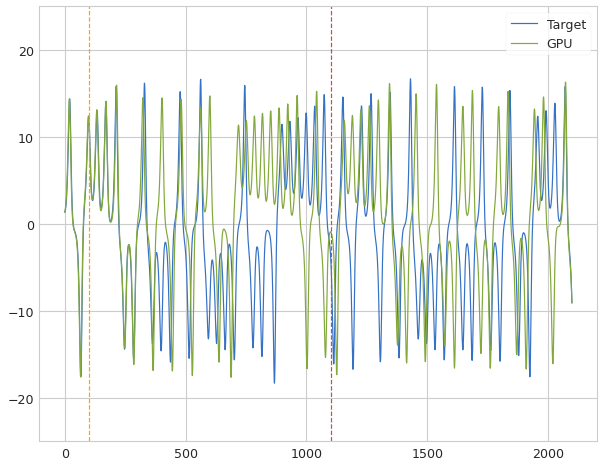

 Iter=65 a=0.542 sr=1.343 amp=1.000  ri=0.083 rr=2.635 loss=0.917201 nrmse=0.239934 CD 0.677267
Iter: 65 #### Time 3.90  NRMSE 0.240 CD 0.677
Iter: 66 #### Time 3.85  NRMSE 0.351 CD 1.084
Iter: 67 #### Time 3.79  NRMSE 0.293 CD 0.991
Iter: 68 #### Time 3.77  NRMSE 0.384 CD 0.892
Iter: 69 #### Time 3.77  NRMSE 7.479 CD 0.908
Iter: 70 #### Time 3.78  NRMSE 1000.000 CD nan
Iter: 71 #### Time 3.78  NRMSE 1000.000 CD nan
Iter: 72 #### Time 3.77  NRMSE 0.288 CD 0.961
Iter: 73 #### Time 3.79  NRMSE 0.766 CD 0.971
Iter: 74 #### Time 3.88  NRMSE 1000.000 CD nan
Iter: 75 #### Time 3.78  NRMSE 0.293 CD 0.944
Iter: 76 #### Time 3.78  NRMSE 1000.000 CD nan
Iter: 77 #### Time 3.79  NRMSE 0.287 CD 0.897
Iter: 78 #### Time 3.77  NRMSE 0.565 CD 0.933
Iter: 79 #### Time 3.79  NRMSE 0.888 CD 0.961
Iter: 80 #### Time 3.77  NRMSE 1.423 CD 1.374
Iter: 81 #### Time 3.81  NRMSE 4.162 CD 0.995
Iter: 82 #### Time 3.79  NRMSE 0.241 CD 1.113
Iter: 83 #### Time 3.77  NRMSE 0.301 CD 1.003
Iter: 84 #### Time 3.79  N

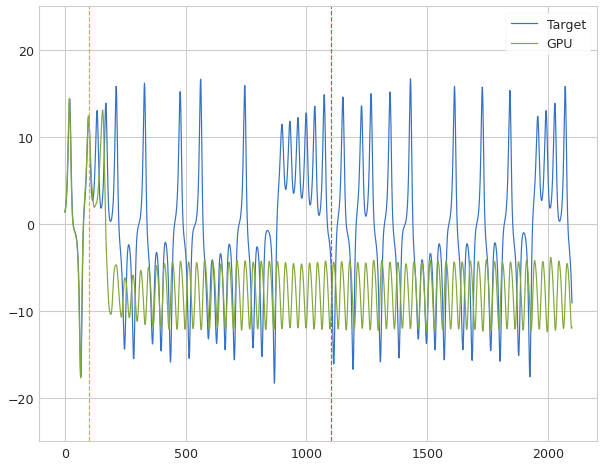

 Iter=2 a=0.610 sr=1.312 amp=1.000  ri=0.003 rr=2.665 loss=1.111670 nrmse=0.275429 CD 0.836242
Iter: 2 #### Time 3.90  NRMSE 0.275 CD 0.836
Iter: 3 #### Time 3.81  NRMSE 0.281 CD 0.905
Iter: 4 #### Time 3.77  NRMSE 0.719 CD 0.911
Iter: 5 #### Time 3.76  NRMSE 1000.000 CD nan
Iter: 6 #### Time 3.80  NRMSE 0.318 CD 1.109
Iter: 7 #### Time 3.80  NRMSE 1000.000 CD nan
Iter: 8 #### Time 3.76  NRMSE 4.492 CD 1.000
Iter: 9 #### Time 3.77  NRMSE 0.326 CD 1.075
Iter: 10 #### Time 3.77  NRMSE 1.990 CD 0.999
Iter: 11 #### Time 3.75  NRMSE 0.313 CD 1.060
Iter: 12 #### Time 3.76  NRMSE 0.296 CD 1.067
Iter: 13 #### Time 3.77  NRMSE 1000.000 CD nan
Iter: 14 #### Time 3.81  NRMSE 0.353 CD 1.062
Iter: 15 #### Time 3.76  NRMSE 0.291 CD 0.950
Iter: 16 #### Time 3.78  NRMSE 0.452 CD 0.995
Iter: 17 #### Time 3.78  NRMSE 0.350 CD 0.894
Iter: 18 #### Time 3.77  NRMSE 0.379 CD 0.944
Iter: 19 #### Time 3.78  NRMSE 1000.000 CD nan
Iter: 20 #### Time 3.77  NRMSE 0.273 CD 0.883
Iter: 21 #### Time 3.77  NRMSE 1000

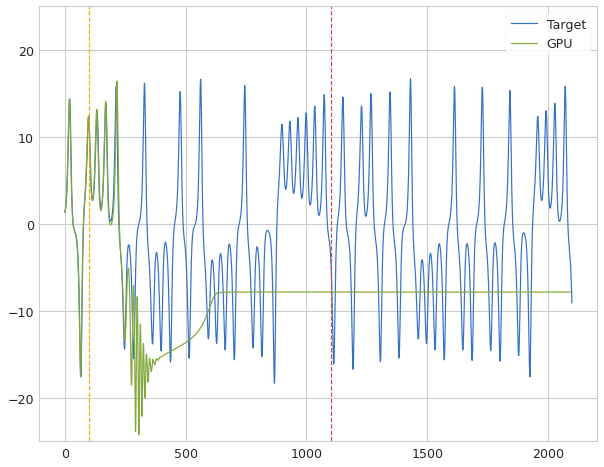

 Iter=22 a=0.768 sr=1.235 amp=1.000  ri=0.084 rr=2.581 loss=1.025777 nrmse=0.298028 CD 0.727749
Iter: 22 #### Time 3.88  NRMSE 0.298 CD 0.728
Iter: 23 #### Time 3.78  NRMSE 0.805 CD 0.977
Iter: 24 #### Time 3.76  NRMSE 1.200 CD 0.998
Iter: 25 #### Time 3.77  NRMSE 1000.000 CD nan
Iter: 26 #### Time 3.77  NRMSE 1000.000 CD nan
Iter: 27 #### Time 3.81  NRMSE 1000.000 CD nan
Iter: 28 #### Time 3.78  NRMSE 0.278 CD 0.796
Iter: 29 #### Time 3.76  NRMSE 0.297 CD 1.020
Iter: 30 #### Time 3.77  NRMSE 0.277 CD 1.039
Iter: 31 #### Time 3.76  NRMSE 0.355 CD 1.063
Iter: 32 #### Time 3.77  NRMSE 1.084 CD 0.952
Iter: 33 #### Time 3.78  NRMSE 1.968 CD 0.995
Iter: 34 #### Time 3.77  NRMSE 1000.000 CD nan
Iter: 35 #### Time 3.76  NRMSE 0.279 CD 0.892
Iter: 36 #### Time 3.78  NRMSE 1000.000 CD nan
Iter: 37 #### Time 3.78  NRMSE 1000.000 CD nan
Iter: 38 #### Time 3.76  NRMSE 0.643 CD 0.942
Iter: 39 #### Time 3.77  NRMSE 1000.000 CD nan
Iter: 40 #### Time 3.76  NRMSE 0.497 CD 1.046
Iter: 41 #### Time 3.77

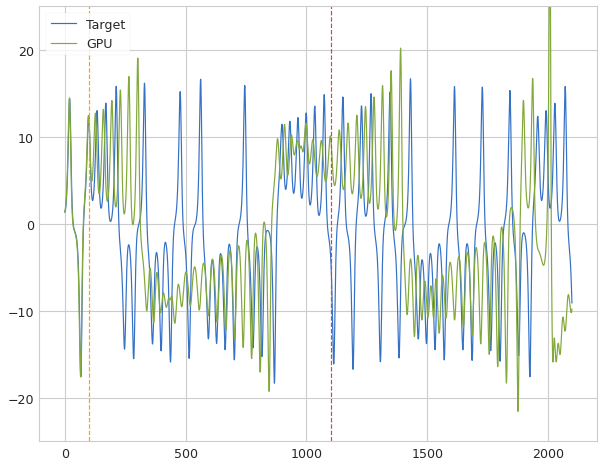

 Iter=114 a=0.570 sr=1.200 amp=1.000  ri=0.065 rr=3.000 loss=0.777971 nrmse=0.223746 CD 0.554225
Iter: 114 #### Time 4.10  NRMSE 0.224 CD 0.554
Iter: 115 #### Time 3.96  NRMSE 0.461 CD 0.972
Iter: 116 #### Time 3.95  NRMSE 0.321 CD 1.056
Iter: 117 #### Time 3.94  NRMSE 0.899 CD 0.889
Iter: 118 #### Time 3.79  NRMSE 0.285 CD 0.959
Iter: 119 #### Time 3.98  NRMSE 0.473 CD 1.072
Iter: 120 #### Time 3.86  NRMSE 0.319 CD 1.053
Iter: 121 #### Time 3.79  NRMSE 0.314 CD 1.068
Iter: 122 #### Time 4.09  NRMSE 1000.000 CD nan
Iter: 123 #### Time 4.05  NRMSE 1000.000 CD nan
Iter: 124 #### Time 3.99  NRMSE 0.256 CD 0.743
Iter: 125 #### Time 3.93  NRMSE 0.350 CD 1.066
Iter: 126 #### Time 4.01  NRMSE 1000.000 CD nan
Iter: 127 #### Time 3.97  NRMSE 0.304 CD 0.983
Iter: 128 #### Time 3.96  NRMSE 0.370 CD 1.111
Iter: 129 #### Time 3.98  NRMSE 0.408 CD 0.922
Iter: 130 #### Time 3.96  NRMSE 0.343 CD 0.934
Iter: 131 #### Time 3.97  NRMSE 1000.000 CD nan
Iter: 132 #### Time 3.98  NRMSE 0.319 CD 1.061
Iter: 

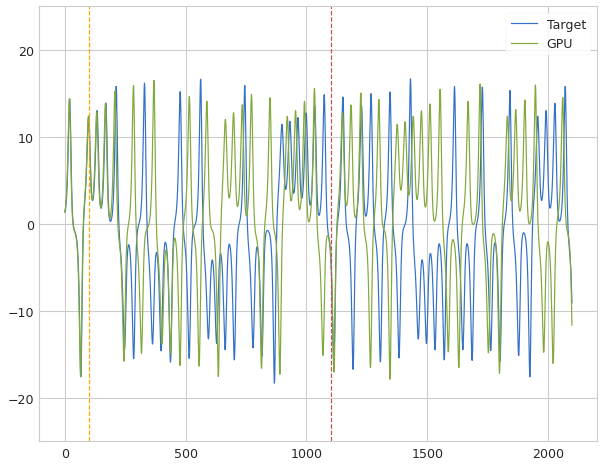

 Iter=3 a=0.540 sr=1.268 amp=1.000  ri=0.047 rr=2.527 loss=1.228147 nrmse=0.283724 CD 0.944423
Iter: 3 #### Time 4.08  NRMSE 0.284 CD 0.944
Iter: 4 #### Time 3.96  NRMSE 1.169 CD 1.005
Iter: 5 #### Time 3.94  NRMSE 1000.000 CD nan
Iter: 6 #### Time 3.94  NRMSE 1000.000 CD nan
Iter: 7 #### Time 3.94  NRMSE 1000.000 CD nan
Iter: 8 #### Time 3.95  NRMSE 0.324 CD 1.061
Dist 0.819313


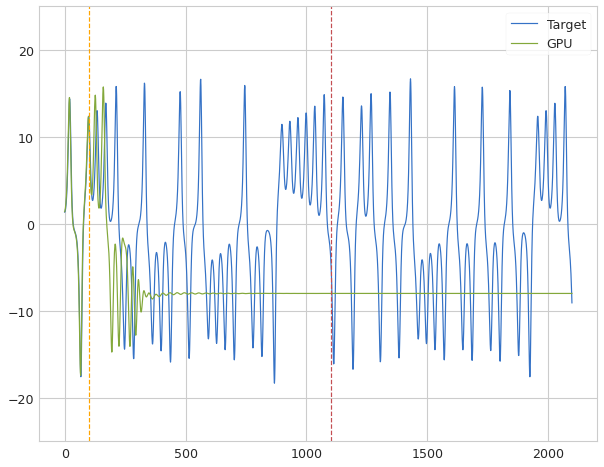

 Iter=9 a=0.597 sr=1.362 amp=1.000  ri=0.097 rr=2.798 loss=1.089390 nrmse=0.270078 CD 0.819313
Iter: 9 #### Time 4.06  NRMSE 0.270 CD 0.819
Iter: 10 #### Time 3.96  NRMSE 1000.000 CD nan
Iter: 11 #### Time 3.98  NRMSE 2.604 CD 0.995
Iter: 12 #### Time 3.95  NRMSE 2.761 CD 1.000
Iter: 13 #### Time 5.08  NRMSE 1.757 CD 1.000
Iter: 14 #### Time 5.34  NRMSE 1000.000 CD nan
Iter: 15 #### Time 5.30  NRMSE 2.360 CD 0.928
Iter: 16 #### Time 5.31  NRMSE 0.930 CD 0.892
Iter: 17 #### Time 5.27  NRMSE 0.487 CD 0.976
Iter: 18 #### Time 5.29  NRMSE 0.318 CD 1.060
Iter: 19 #### Time 3.87  NRMSE 1000.000 CD nan
Dist 0.781456


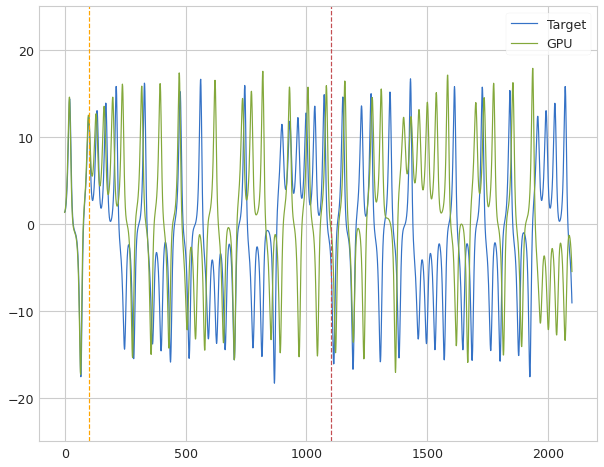

 Iter=20 a=0.580 sr=1.321 amp=1.000  ri=0.077 rr=2.158 loss=1.042319 nrmse=0.260863 CD 0.781456
Iter: 20 #### Time 3.91  NRMSE 0.261 CD 0.781
Iter: 21 #### Time 3.80  NRMSE 0.291 CD 0.959
Iter: 22 #### Time 3.79  NRMSE 0.459 CD 0.986
Iter: 23 #### Time 3.77  NRMSE 0.599 CD 0.971
Iter: 24 #### Time 3.79  NRMSE 0.330 CD 1.065
Iter: 25 #### Time 3.80  NRMSE 0.457 CD 1.074
Iter: 26 #### Time 3.79  NRMSE 0.724 CD 1.001
Iter: 27 #### Time 3.79  NRMSE 0.335 CD 1.067
Iter: 28 #### Time 3.78  NRMSE 1000.000 CD nan
Iter: 29 #### Time 3.79  NRMSE 0.315 CD 0.968
Iter: 30 #### Time 3.78  NRMSE 0.303 CD 1.061
Iter: 31 #### Time 3.78  NRMSE 0.507 CD 1.006
Iter: 32 #### Time 3.78  NRMSE 0.382 CD 0.955
Iter: 33 #### Time 3.79  NRMSE 1000.000 CD nan
Iter: 34 #### Time 3.78  NRMSE 0.332 CD 1.039
Iter: 35 #### Time 3.79  NRMSE 1000.000 CD nan
Iter: 36 #### Time 3.81  NRMSE 1000.000 CD nan
Iter: 37 #### Time 3.77  NRMSE 17.805 CD 1.108
Iter: 38 #### Time 3.84  NRMSE 0.340 CD 1.071
Iter: 39 #### Time 3.79  

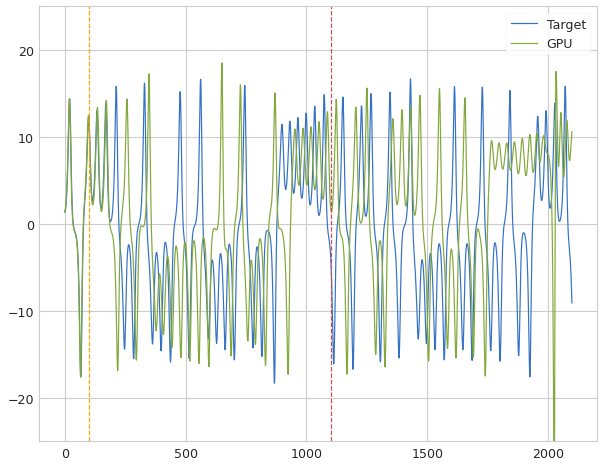

 Iter=62 a=0.505 sr=1.216 amp=1.000  ri=0.020 rr=2.007 loss=1.040348 nrmse=0.260306 CD 0.780042
Iter: 62 #### Time 3.92  NRMSE 0.260 CD 0.780
Iter: 63 #### Time 3.79  NRMSE 1000.000 CD nan
Iter: 64 #### Time 3.79  NRMSE 0.286 CD 1.049
Iter: 65 #### Time 3.79  NRMSE 1000.000 CD nan
Iter: 66 #### Time 3.78  NRMSE 0.303 CD 1.006
Iter: 67 #### Time 3.88  NRMSE 1000.000 CD nan
Iter: 68 #### Time 3.81  NRMSE 0.227 CD 1.034
Iter: 69 #### Time 3.82  NRMSE 1000.000 CD nan
Iter: 70 #### Time 3.77  NRMSE 2.710 CD 1.001
Iter: 71 #### Time 3.83  NRMSE 0.595 CD 1.001
Iter: 72 #### Time 3.78  NRMSE 1.450 CD 0.978
Iter: 73 #### Time 3.80  NRMSE 0.277 CD 0.824
Iter: 74 #### Time 3.79  NRMSE 0.312 CD 0.934
Iter: 75 #### Time 3.79  NRMSE 2.088 CD 1.007
Iter: 76 #### Time 3.79  NRMSE 0.309 CD 1.040
Iter: 77 #### Time 3.78  NRMSE 0.259 CD 0.876
Iter: 78 #### Time 3.80  NRMSE 1.681 CD 1.002
Iter: 79 #### Time 3.80  NRMSE 0.316 CD 1.057
Iter: 80 #### Time 3.81  NRMSE 0.321 CD 1.058
Iter: 81 #### Time 3.80  N

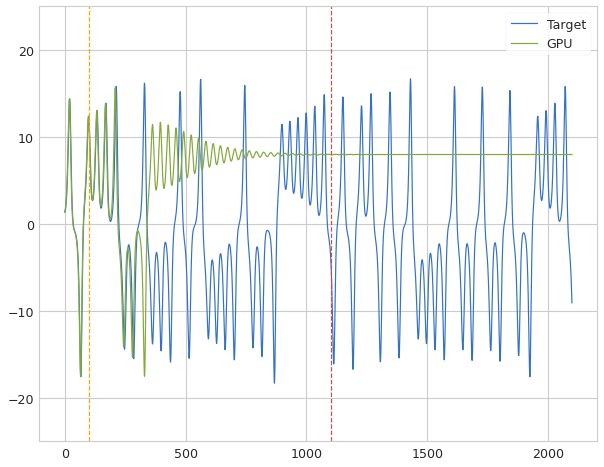

 Iter=3 a=0.814 sr=1.318 amp=1.000  ri=0.074 rr=2.673 loss=1.264252 nrmse=0.289881 CD 0.974371
Iter: 3 #### Time 4.08  NRMSE 0.290 CD 0.974
Iter: 4 #### Time 3.94  NRMSE 22624050954353320504555232292765696.000 CD 1.000
Iter: 5 #### Time 3.98  NRMSE 1000.000 CD nan
Iter: 6 #### Time 4.00  NRMSE 1000.000 CD nan
Iter: 7 #### Time 3.92  NRMSE 1.102 CD 0.971
Iter: 8 #### Time 3.86  NRMSE 0.905 CD 0.965
Iter: 9 #### Time 3.87  NRMSE 0.411 CD 1.141
Iter: 10 #### Time 3.79  NRMSE 0.352 CD 0.919
Dist 0.870663


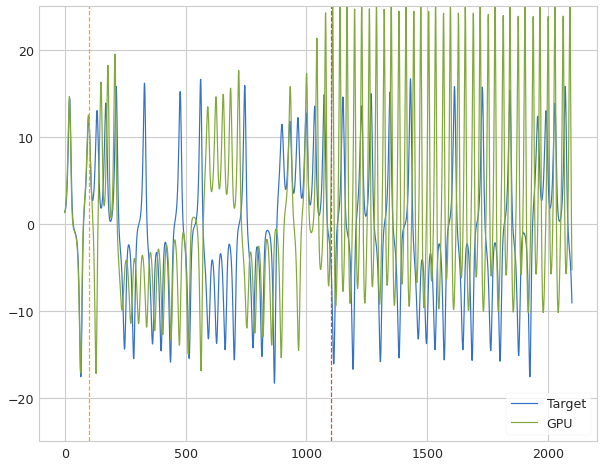

 Iter=11 a=0.502 sr=1.385 amp=1.000  ri=0.068 rr=2.988 loss=1.152962 nrmse=0.282299 CD 0.870663
Iter: 11 #### Time 4.19  NRMSE 0.282 CD 0.871
Dist 0.833845


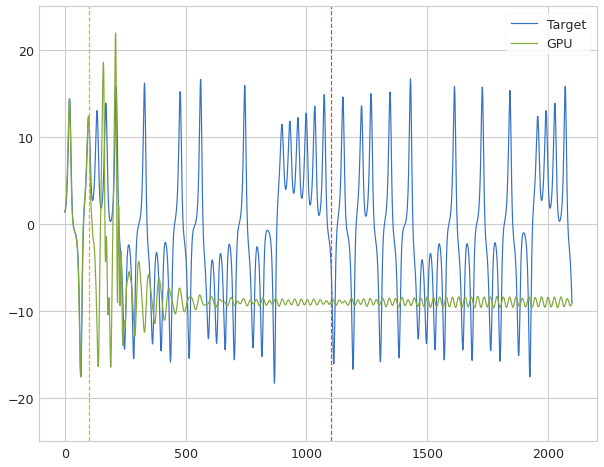

 Iter=12 a=0.688 sr=1.365 amp=1.000  ri=0.006 rr=2.744 loss=1.123759 nrmse=0.289914 CD 0.833845
Iter: 12 #### Time 4.43  NRMSE 0.290 CD 0.834
Dist 0.785051


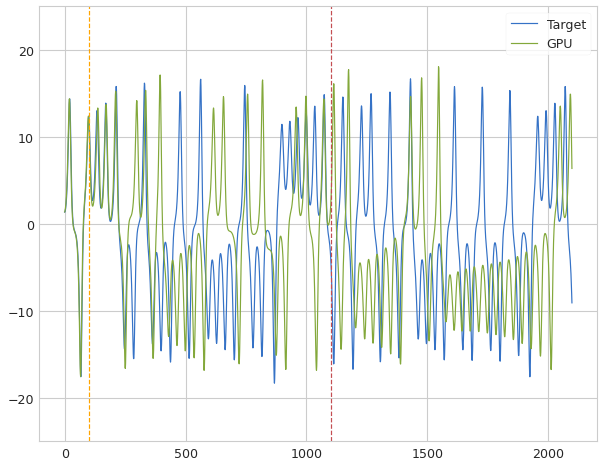

 Iter=13 a=0.605 sr=1.395 amp=1.000  ri=0.067 rr=2.994 loss=1.041128 nrmse=0.256077 CD 0.785051
Iter: 13 #### Time 5.42  NRMSE 0.256 CD 0.785
Iter: 14 #### Time 5.31  NRMSE 6.771 CD 1.001
Iter: 15 #### Time 5.26  NRMSE 0.300 CD 0.998
Iter: 16 #### Time 5.26  NRMSE 0.321 CD 1.076
Iter: 17 #### Time 5.27  NRMSE 1000.000 CD nan
Iter: 18 #### Time 5.30  NRMSE 0.814 CD 0.983
Iter: 19 #### Time 5.25  NRMSE 1000.000 CD nan
Iter: 20 #### Time 5.26  NRMSE 0.544 CD 0.839
Iter: 21 #### Time 5.27  NRMSE 3.543 CD 1.167
Iter: 22 #### Time 5.26  NRMSE 2.757 CD 0.984
Iter: 23 #### Time 5.30  NRMSE 0.346 CD 1.103
Iter: 24 #### Time 5.26  NRMSE 1000.000 CD nan
Dist 0.770697


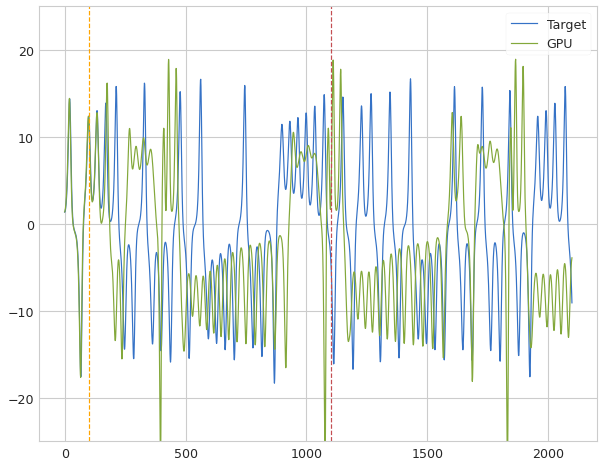

 Iter=25 a=0.602 sr=1.345 amp=1.000  ri=0.091 rr=2.877 loss=1.039616 nrmse=0.268920 CD 0.770697
Iter: 25 #### Time 5.39  NRMSE 0.269 CD 0.771
Dist 0.766998


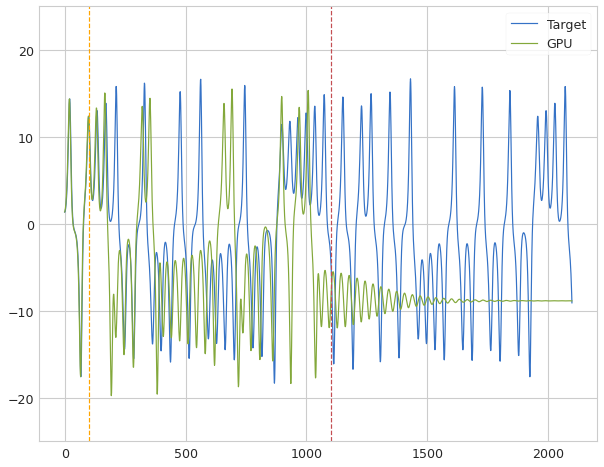

 Iter=26 a=0.823 sr=1.233 amp=1.000  ri=0.036 rr=2.165 loss=1.038155 nrmse=0.271157 CD 0.766998
Iter: 26 #### Time 5.38  NRMSE 0.271 CD 0.767
Iter: 27 #### Time 5.25  NRMSE 1.104 CD 0.998
Iter: 28 #### Time 5.24  NRMSE 0.333 CD 1.263
Iter: 29 #### Time 5.25  NRMSE 0.322 CD 1.063
Iter: 30 #### Time 5.25  NRMSE 1000.000 CD nan
Iter: 31 #### Time 5.25  NRMSE 0.304 CD 1.053
Iter: 32 #### Time 5.29  NRMSE 1.111 CD 1.096
Iter: 33 #### Time 3.84  NRMSE 1.311 CD 0.948
Iter: 34 #### Time 3.77  NRMSE 1.306 CD 0.995
Iter: 35 #### Time 3.78  NRMSE 5.440 CD 0.891
Iter: 36 #### Time 3.78  NRMSE 1000.000 CD nan
Iter: 37 #### Time 3.77  NRMSE 0.318 CD 1.054
Iter: 38 #### Time 3.77  NRMSE 1000.000 CD nan
Iter: 39 #### Time 3.77  NRMSE 0.274 CD 0.870
Iter: 40 #### Time 3.77  NRMSE 0.280 CD 0.822
Iter: 41 #### Time 3.77  NRMSE 0.261 CD 0.804
Iter: 42 #### Time 3.78  NRMSE 0.287 CD 0.956
Iter: 43 #### Time 3.79  NRMSE 1000.000 CD nan
Iter: 44 #### Time 3.80  NRMSE 1000.000 CD nan
Iter: 45 #### Time 3.80  

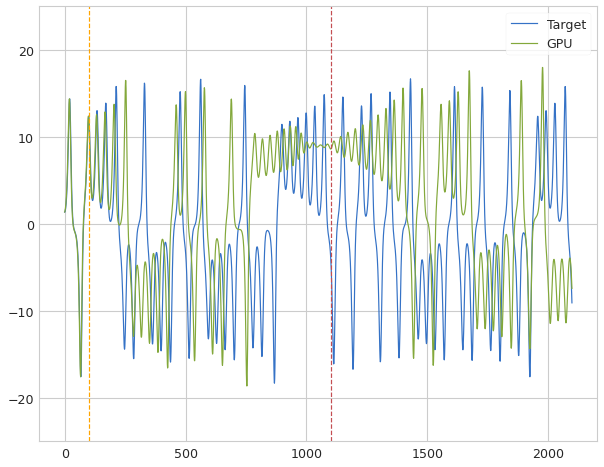

 Iter=120 a=0.700 sr=1.244 amp=1.000  ri=0.095 rr=2.775 loss=0.994639 nrmse=0.255938 CD 0.738701
Iter: 120 #### Time 4.16  NRMSE 0.256 CD 0.739
Iter: 121 #### Time 4.01  NRMSE 0.289 CD 0.960
Iter: 122 #### Time 3.96  NRMSE 0.279 CD 0.887
Iter: 123 #### Time 3.98  NRMSE 1000.000 CD nan
Iter: 124 #### Time 3.93  NRMSE 0.316 CD 0.817
Dist 0.660530


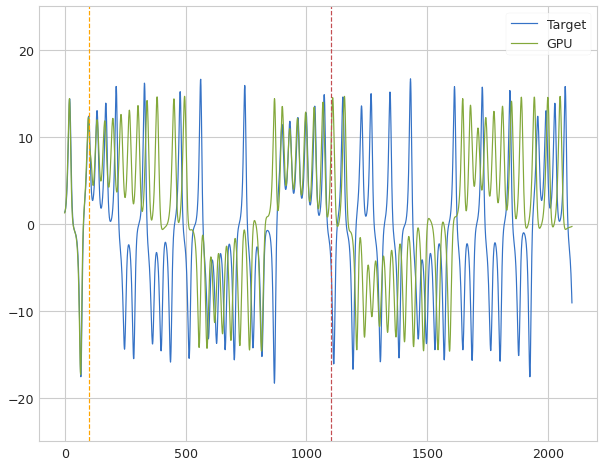

 Iter=125 a=0.614 sr=1.332 amp=1.000  ri=0.076 rr=2.509 loss=0.896744 nrmse=0.236214 CD 0.660530
Iter: 125 #### Time 4.06  NRMSE 0.236 CD 0.661
Iter: 126 #### Time 3.95  NRMSE 0.324 CD 1.058
Iter: 127 #### Time 4.00  NRMSE 0.316 CD 1.051
Iter: 128 #### Time 3.99  NRMSE 1.307 CD 0.997
Iter: 129 #### Time 3.99  NRMSE 0.327 CD 1.157
Iter: 130 #### Time 3.97  NRMSE 0.426 CD 0.890
Iter: 131 #### Time 3.97  NRMSE 2.136 CD 1.007
Iter: 132 #### Time 4.00  NRMSE 0.307 CD 1.133
Iter: 133 #### Time 3.97  NRMSE 0.278 CD 0.916
Iter: 134 #### Time 3.97  NRMSE 0.412 CD 0.954
Iter: 135 #### Time 4.08  NRMSE 3.459 CD 0.954
Iter: 136 #### Time 3.85  NRMSE 0.424 CD 0.834
Iter: 137 #### Time 4.06  NRMSE 0.428 CD 1.048
Iter: 138 #### Time 4.10  NRMSE 0.320 CD 1.061
Iter: 139 #### Time 5.30  NRMSE 0.286 CD 0.918
Iter: 140 #### Time 3.85  NRMSE 1000.000 CD nan
Iter: 141 #### Time 3.91  NRMSE 2.276 CD 0.995
Iter: 142 #### Time 4.05  NRMSE 0.266 CD 0.828
Iter: 143 #### Time 3.94  NRMSE 0.479 CD 1.000
Iter: 144

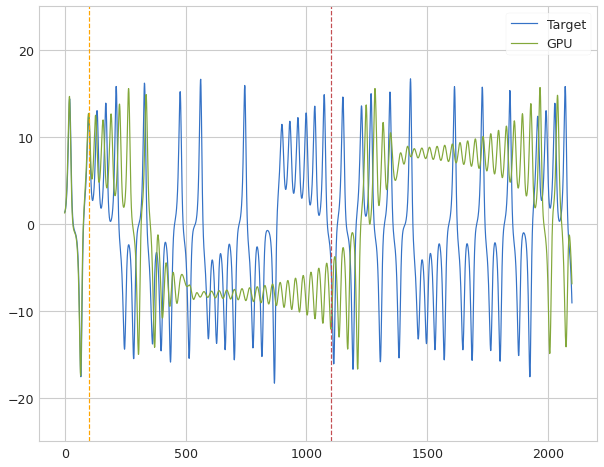

 Iter=0 a=0.556 sr=1.305 amp=1.000  ri=0.076 rr=2.310 loss=1.080623 nrmse=0.267315 CD 0.813309
Iter: 0 #### Time 4.09  NRMSE 0.267 CD 0.813
Iter: 1 #### Time 3.95  NRMSE 1000.000 CD nan
Iter: 2 #### Time 3.94  NRMSE 1000.000 CD nan
Iter: 3 #### Time 4.01  NRMSE 0.309 CD 1.047
Iter: 4 #### Time 3.95  NRMSE 0.340 CD 1.007
Iter: 5 #### Time 3.94  NRMSE 1.213 CD 1.052
Iter: 6 #### Time 3.95  NRMSE 0.477 CD 0.968
Iter: 7 #### Time 3.94  NRMSE 0.321 CD 1.056
Iter: 8 #### Time 3.95  NRMSE 0.314 CD 1.062
Iter: 9 #### Time 3.96  NRMSE 35.790 CD 0.898
Iter: 10 #### Time 3.94  NRMSE 0.325 CD 1.070
Iter: 11 #### Time 3.95  NRMSE 0.637 CD 0.992
Iter: 12 #### Time 3.96  NRMSE 0.290 CD 0.947
Iter: 13 #### Time 3.96  NRMSE 0.285 CD 0.927
Iter: 14 #### Time 3.96  NRMSE 1000.000 CD nan
Iter: 15 #### Time 3.95  NRMSE 0.302 CD 1.048
Iter: 16 #### Time 3.95  NRMSE 0.317 CD 1.066
Iter: 17 #### Time 3.94  NRMSE 4.945 CD 1.106
Iter: 18 #### Time 3.94  NRMSE 0.329 CD 1.261
Iter: 19 #### Time 3.94  NRMSE 0.323 

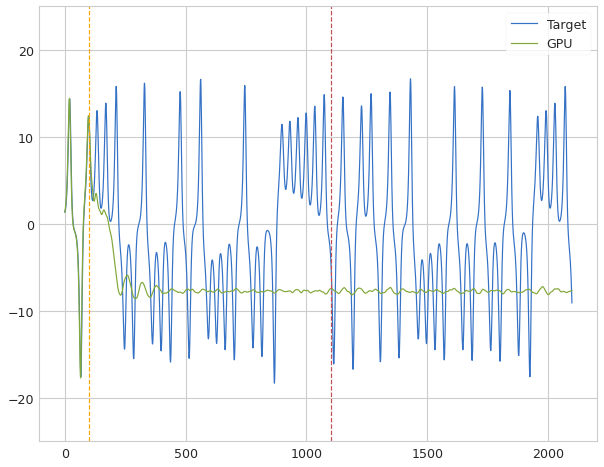

 Iter=65 a=0.584 sr=1.338 amp=1.000  ri=0.002 rr=2.425 loss=1.079507 nrmse=0.257624 CD 0.821883
Iter: 65 #### Time 4.18  NRMSE 0.258 CD 0.822
Iter: 66 #### Time 3.94  NRMSE 0.287 CD 0.911
Iter: 67 #### Time 3.95  NRMSE 1.027 CD 1.001
Iter: 68 #### Time 3.94  NRMSE 0.526 CD 0.948
Iter: 69 #### Time 3.95  NRMSE 0.349 CD 1.182
Iter: 70 #### Time 3.95  NRMSE 1000.000 CD nan
Iter: 71 #### Time 3.96  NRMSE 0.273 CD 0.905
Iter: 72 #### Time 3.94  NRMSE 0.315 CD 1.046
Iter: 73 #### Time 3.97  NRMSE 1000.000 CD nan
Iter: 74 #### Time 3.94  NRMSE 0.334 CD 1.070
Iter: 75 #### Time 3.95  NRMSE 1000.000 CD nan
Iter: 76 #### Time 3.96  NRMSE 1000.000 CD nan
Iter: 77 #### Time 3.94  NRMSE 0.705 CD 1.032
Iter: 78 #### Time 3.94  NRMSE 1.004 CD 1.072
Iter: 79 #### Time 3.95  NRMSE 0.323 CD 0.911
Iter: 80 #### Time 3.94  NRMSE 0.305 CD 0.901
Iter: 81 #### Time 3.96  NRMSE 0.883 CD 0.989
Iter: 82 #### Time 3.94  NRMSE 2.857 CD 0.995
Iter: 83 #### Time 3.94  NRMSE 0.296 CD 1.032
Iter: 84 #### Time 3.95  N

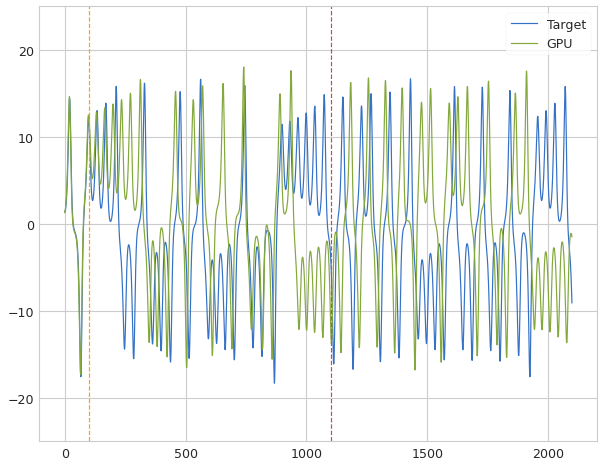

 Iter=111 a=0.721 sr=1.400 amp=1.000  ri=0.069 rr=2.439 loss=1.062630 nrmse=0.263557 CD 0.799074
Iter: 111 #### Time 4.04  NRMSE 0.264 CD 0.799
Iter: 112 #### Time 3.80  NRMSE 0.417 CD 0.933
Iter: 113 #### Time 3.78  NRMSE 1.410 CD 1.085
Iter: 114 #### Time 3.79  NRMSE 1000.000 CD nan
Iter: 115 #### Time 3.94  NRMSE 1000.000 CD nan
Iter: 116 #### Time 3.78  NRMSE 0.275 CD 0.895
Iter: 117 #### Time 3.78  NRMSE 0.294 CD 1.050
Iter: 118 #### Time 3.77  NRMSE 0.461 CD 0.997
Iter: 119 #### Time 3.78  NRMSE 0.323 CD 1.057
Iter: 120 #### Time 3.76  NRMSE 0.287 CD 0.847
Iter: 121 #### Time 3.78  NRMSE 0.344 CD 1.051
Iter: 122 #### Time 3.78  NRMSE 1000.000 CD nan
Iter: 123 #### Time 3.79  NRMSE 0.321 CD 1.079
Iter: 124 #### Time 3.79  NRMSE 0.281 CD 0.929
Iter: 125 #### Time 3.77  NRMSE 0.410 CD 0.846
Iter: 126 #### Time 3.76  NRMSE 4.157 CD 1.127
Iter: 127 #### Time 3.80  NRMSE 5.397 CD 0.906
Iter: 128 #### Time 3.80  NRMSE 1.052 CD 1.133
Iter: 129 #### Time 3.80  NRMSE 0.312 CD 1.182
Iter: 1

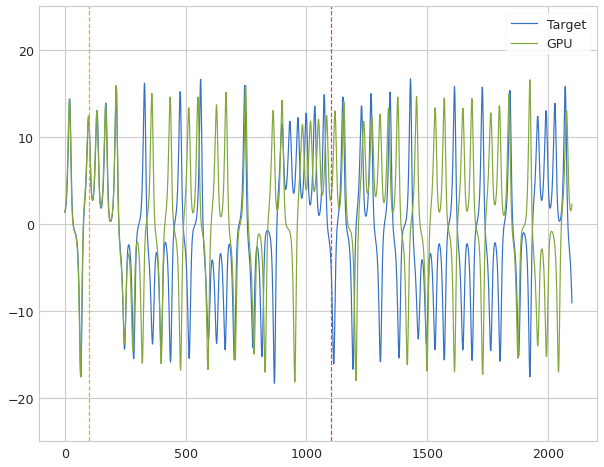

 Iter=133 a=0.599 sr=1.374 amp=1.000  ri=0.073 rr=2.074 loss=1.021820 nrmse=0.255757 CD 0.766063
Iter: 133 #### Time 3.94  NRMSE 0.256 CD 0.766
Iter: 134 #### Time 3.81  NRMSE 1000.000 CD nan
Iter: 135 #### Time 3.85  NRMSE 2.602 CD 1.002
Iter: 136 #### Time 3.80  NRMSE 0.292 CD 0.990
Iter: 137 #### Time 3.85  NRMSE 0.632 CD 1.134
Iter: 138 #### Time 3.82  NRMSE 0.322 CD 1.060
Iter: 139 #### Time 3.81  NRMSE 0.353 CD 0.964
Iter: 140 #### Time 3.84  NRMSE 1000.000 CD nan
Dist 0.744595


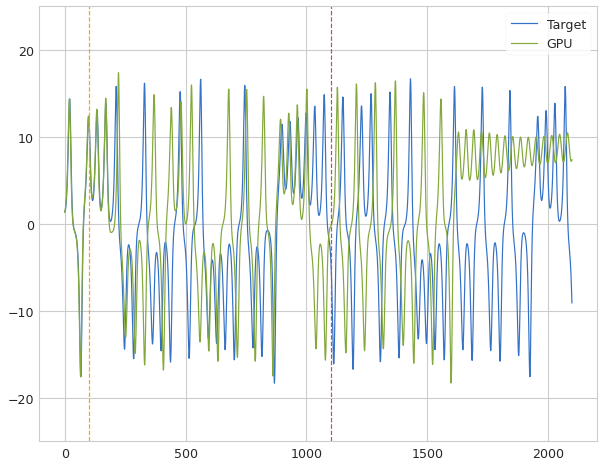

 Iter=141 a=0.833 sr=1.326 amp=1.000  ri=0.066 rr=2.371 loss=0.997961 nrmse=0.253366 CD 0.744595
Iter: 141 #### Time 3.95  NRMSE 0.253 CD 0.745
Iter: 142 #### Time 3.83  NRMSE 0.324 CD 1.060
Iter: 143 #### Time 3.83  NRMSE 0.267 CD 0.813
Iter: 144 #### Time 3.82  NRMSE 0.819 CD 0.954
Iter: 145 #### Time 5.31  NRMSE 0.313 CD 0.766
Iter: 146 #### Time 5.29  NRMSE 0.295 CD 1.025
Iter: 147 #### Time 5.30  NRMSE 0.693 CD 0.868
Iter: 148 #### Time 3.81  NRMSE 0.306 CD 1.019
Iter: 149 #### Time 3.84  NRMSE 0.284 CD 0.919
End Run 1 Time 712.797

Best result = 0.9979612763565
a = 0.8333890982908732
sr = 1.3263704970331596
amp = 0.06618058888185431
ri = 2.3712056230010337
********** Size 50 -- Run 2 ***********
Iter: 0 #### Time 3.86  NRMSE 1000.000 CD nan
Iter: 1 #### Time 3.83  NRMSE 1000.000 CD nan
Iter: 2 #### Time 3.79  NRMSE 42.822 CD 1.069
Iter: 3 #### Time 4.00  NRMSE 1000.000 CD nan
Iter: 4 #### Time 3.98  NRMSE 1000.000 CD nan
Iter: 5 #### Time 4.01  NRMSE 0.802 CD 1.004
Iter: 6 #### T

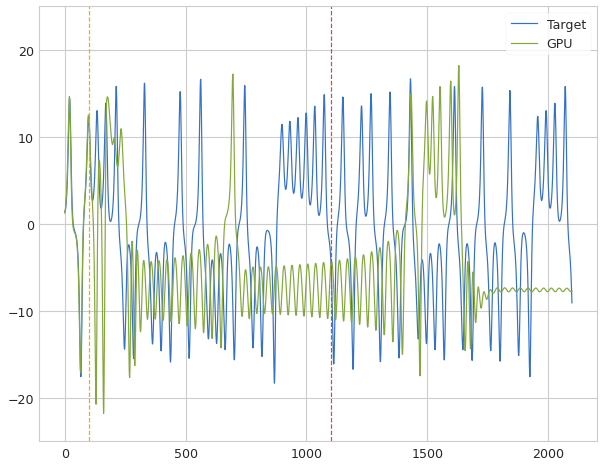

 Iter=10 a=0.725 sr=1.350 amp=1.000  ri=0.061 rr=2.203 loss=1.253764 nrmse=0.292894 CD 0.960870
Iter: 10 #### Time 4.10  NRMSE 0.293 CD 0.961
Iter: 11 #### Time 3.95  NRMSE 1.337 CD 0.993
Iter: 12 #### Time 3.94  NRMSE 1000.000 CD nan
Iter: 13 #### Time 3.93  NRMSE 2.124 CD 0.997
Iter: 14 #### Time 3.89  NRMSE 0.348 CD 0.991
Iter: 15 #### Time 3.81  NRMSE 2.102 CD 1.011
Iter: 16 #### Time 3.81  NRMSE 1000.000 CD nan
Iter: 17 #### Time 3.77  NRMSE 1.532 CD 1.004
Iter: 18 #### Time 3.82  NRMSE 1000.000 CD nan
Iter: 19 #### Time 3.78  NRMSE 0.316 CD 0.897
Iter: 20 #### Time 3.77  NRMSE 1000.000 CD nan
Iter: 21 #### Time 3.79  NRMSE 0.320 CD 1.062
Dist 0.943916


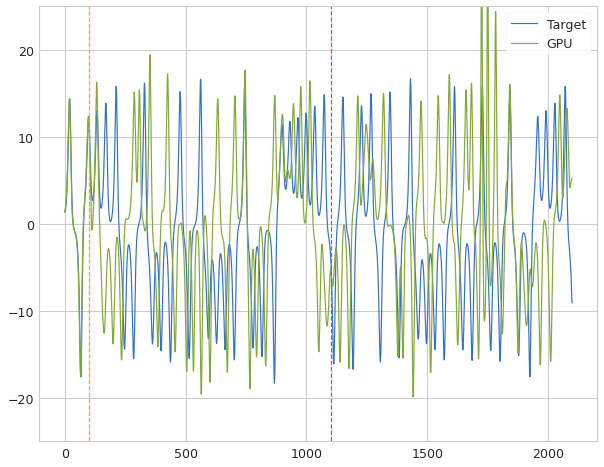

 Iter=22 a=0.828 sr=1.314 amp=1.000  ri=0.088 rr=2.801 loss=1.239252 nrmse=0.295336 CD 0.943916
Iter: 22 #### Time 3.99  NRMSE 0.295 CD 0.944
Iter: 23 #### Time 3.97  NRMSE 0.945 CD 0.991
Iter: 24 #### Time 3.97  NRMSE 0.370 CD 0.963
Dist 0.757356


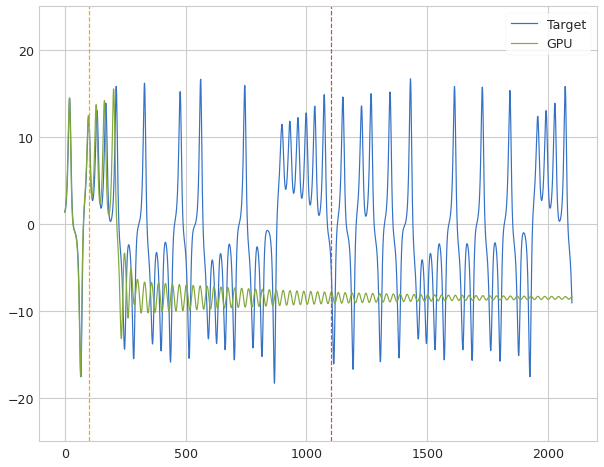

 Iter=25 a=0.593 sr=1.241 amp=1.000  ri=0.096 rr=2.766 loss=1.021525 nrmse=0.264168 CD 0.757356
Iter: 25 #### Time 4.09  NRMSE 0.264 CD 0.757
Iter: 26 #### Time 3.98  NRMSE 0.949 CD 1.021
Iter: 27 #### Time 3.95  NRMSE 0.326 CD 1.200
Iter: 28 #### Time 3.93  NRMSE 0.313 CD 1.061
Iter: 29 #### Time 3.94  NRMSE 0.304 CD 1.030
Iter: 30 #### Time 3.95  NRMSE 0.318 CD 1.088
Iter: 31 #### Time 4.00  NRMSE 1.737 CD 1.005
Iter: 32 #### Time 3.94  NRMSE 0.354 CD 1.139
Iter: 33 #### Time 3.92  NRMSE 0.309 CD 1.060
Iter: 34 #### Time 3.97  NRMSE 1000.000 CD nan
Iter: 35 #### Time 3.94  NRMSE 4.948 CD 1.116
Iter: 36 #### Time 3.92  NRMSE 1000.000 CD nan
Iter: 37 #### Time 3.93  NRMSE 0.324 CD 1.068
Iter: 38 #### Time 3.94  NRMSE 0.418 CD 1.016
Iter: 39 #### Time 3.95  NRMSE 1000.000 CD nan
Iter: 40 #### Time 3.92  NRMSE 3.712 CD 0.905
Iter: 41 #### Time 3.93  NRMSE 0.319 CD 1.050
Iter: 42 #### Time 3.94  NRMSE 2.761 CD 0.995
Iter: 43 #### Time 3.92  NRMSE 1000.000 CD nan
Iter: 44 #### Time 3.93  N

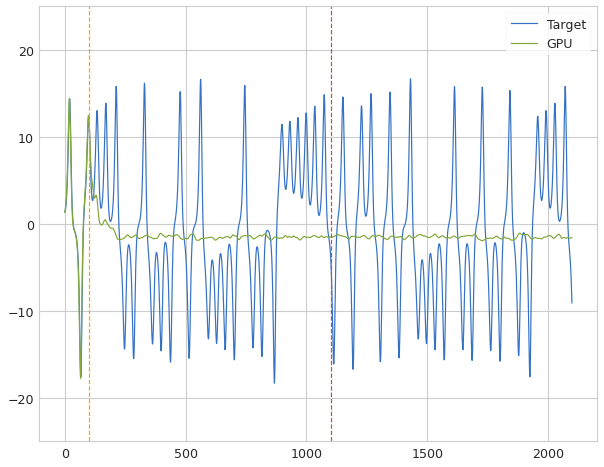

 Iter=88 a=0.534 sr=1.269 amp=1.000  ri=0.002 rr=2.051 loss=0.985546 nrmse=0.202973 CD 0.782573
Iter: 88 #### Time 4.04  NRMSE 0.203 CD 0.783
Iter: 89 #### Time 3.94  NRMSE 1.336 CD 1.007
Iter: 90 #### Time 3.95  NRMSE 1000.000 CD nan
Iter: 91 #### Time 3.93  NRMSE 1000.000 CD nan
Iter: 92 #### Time 3.96  NRMSE 1000.000 CD nan
Iter: 93 #### Time 3.92  NRMSE 1000.000 CD nan
Iter: 94 #### Time 3.92  NRMSE 0.300 CD 1.040
Iter: 95 #### Time 3.93  NRMSE 0.325 CD 1.053
Iter: 96 #### Time 3.92  NRMSE 0.886 CD 1.007
Iter: 97 #### Time 3.94  NRMSE 1000.000 CD nan
Iter: 98 #### Time 3.93  NRMSE 0.534 CD 0.966
Iter: 99 #### Time 3.92  NRMSE 0.301 CD 1.056
Iter: 100 #### Time 3.93  NRMSE 0.381 CD 0.906
Iter: 101 #### Time 3.92  NRMSE 0.314 CD 1.117
Iter: 102 #### Time 3.93  NRMSE 0.769 CD 0.935
Iter: 103 #### Time 3.93  NRMSE 0.342 CD 1.060
Iter: 104 #### Time 3.91  NRMSE 0.467 CD 0.922
Iter: 105 #### Time 3.93  NRMSE 0.314 CD 1.055
Iter: 106 #### Time 3.92  NRMSE 0.320 CD 1.077
Iter: 107 #### Tim

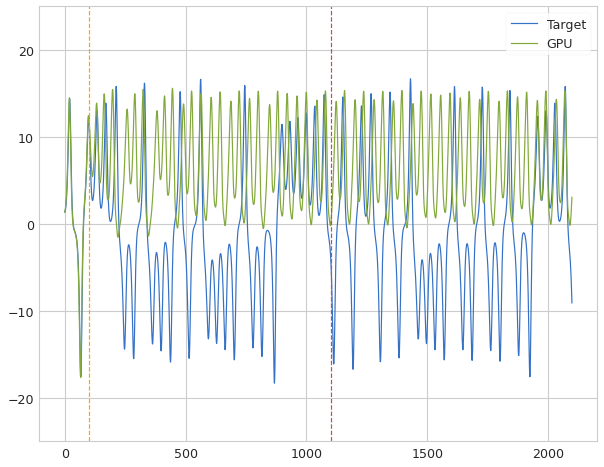

 Iter=2 a=0.610 sr=1.312 amp=1.000  ri=0.003 rr=2.665 loss=1.280182 nrmse=0.299346 CD 0.980836
Iter: 2 #### Time 3.98  NRMSE 0.299 CD 0.981
Iter: 3 #### Time 3.77  NRMSE 1000.000 CD nan
Iter: 4 #### Time 3.88  NRMSE 0.307 CD 0.844
Iter: 5 #### Time 3.77  NRMSE 0.352 CD 0.985
Dist 0.853502


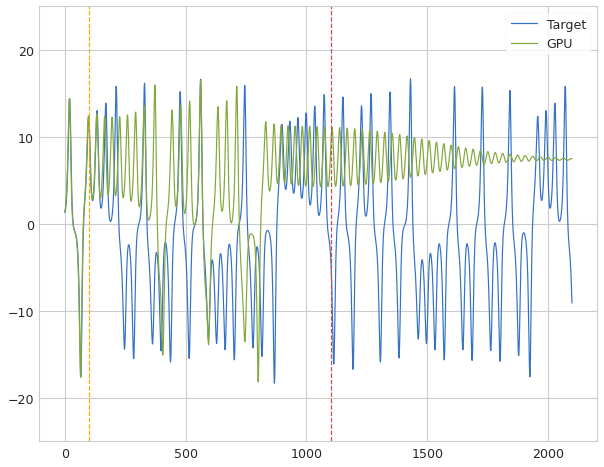

 Iter=6 a=0.638 sr=1.389 amp=1.000  ri=0.092 rr=2.953 loss=1.122385 nrmse=0.268883 CD 0.853502
Iter: 6 #### Time 4.06  NRMSE 0.269 CD 0.854
Iter: 7 #### Time 3.99  NRMSE 1000.000 CD nan
Iter: 8 #### Time 3.94  NRMSE 1.702 CD 0.996
Iter: 9 #### Time 3.96  NRMSE 0.830 CD 0.799
Iter: 10 #### Time 3.93  NRMSE 0.303 CD 0.902
Iter: 11 #### Time 3.93  NRMSE 0.298 CD 0.996
Iter: 12 #### Time 3.93  NRMSE 1000.000 CD nan
Iter: 13 #### Time 3.92  NRMSE 0.323 CD 1.059
Iter: 14 #### Time 3.91  NRMSE 1000.000 CD nan
Iter: 15 #### Time 3.92  NRMSE 0.323 CD 1.060
Iter: 16 #### Time 3.92  NRMSE 0.369 CD 1.155
Iter: 17 #### Time 3.92  NRMSE 1.746 CD 1.003
Iter: 18 #### Time 3.92  NRMSE 0.291 CD 0.931
Iter: 19 #### Time 3.92  NRMSE 0.281 CD 0.930
Iter: 20 #### Time 3.90  NRMSE 0.290 CD 1.006
Iter: 21 #### Time 3.91  NRMSE 1000.000 CD nan
Iter: 22 #### Time 3.91  NRMSE 0.317 CD 1.063
Iter: 23 #### Time 3.92  NRMSE 0.276 CD 0.893
Iter: 24 #### Time 3.91  NRMSE 0.343 CD 1.005
Iter: 25 #### Time 3.96  NRMSE 

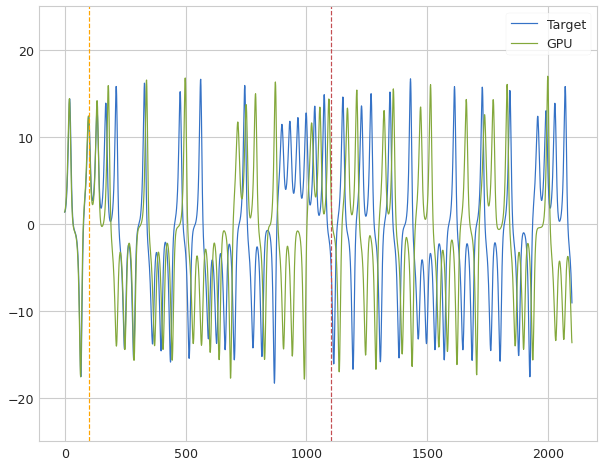

 Iter=35 a=0.573 sr=1.347 amp=1.000  ri=0.077 rr=2.695 loss=1.065815 nrmse=0.264356 CD 0.801459
Iter: 35 #### Time 4.06  NRMSE 0.264 CD 0.801
Iter: 36 #### Time 3.92  NRMSE 1000.000 CD nan
Iter: 37 #### Time 3.92  NRMSE 1.857 CD 1.165
Iter: 38 #### Time 3.91  NRMSE 0.310 CD 1.009
Iter: 39 #### Time 3.91  NRMSE 0.358 CD 1.021
Iter: 40 #### Time 3.92  NRMSE 0.318 CD 1.063
Iter: 41 #### Time 3.91  NRMSE 1000.000 CD nan
Iter: 42 #### Time 3.92  NRMSE 1000.000 CD nan
Iter: 43 #### Time 3.92  NRMSE 0.287 CD 0.933
Iter: 44 #### Time 3.93  NRMSE 0.511 CD 0.646
Iter: 45 #### Time 3.91  NRMSE 0.306 CD 1.060
Iter: 46 #### Time 3.96  NRMSE 1000.000 CD nan
Iter: 47 #### Time 3.97  NRMSE 0.317 CD 1.057
Iter: 48 #### Time 3.96  NRMSE 0.286 CD 0.989
Iter: 49 #### Time 3.92  NRMSE 10.248 CD 1.137
Iter: 50 #### Time 3.93  NRMSE 1000.000 CD nan
Iter: 51 #### Time 3.91  NRMSE 1000.000 CD nan
Dist 0.732221


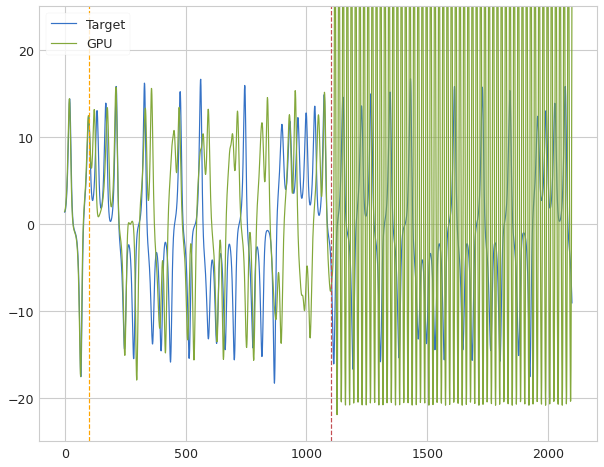

 Iter=52 a=0.860 sr=1.261 amp=1.000  ri=0.081 rr=2.385 loss=0.987875 nrmse=0.255654 CD 0.732221
Iter: 52 #### Time 4.09  NRMSE 0.256 CD 0.732
Iter: 53 #### Time 3.91  NRMSE 0.638 CD 0.956
Iter: 54 #### Time 3.91  NRMSE 0.337 CD 0.812
Iter: 55 #### Time 3.93  NRMSE 0.527 CD 0.978
Iter: 56 #### Time 3.92  NRMSE 0.311 CD 1.064
Iter: 57 #### Time 3.92  NRMSE 0.638 CD 1.088
Iter: 58 #### Time 3.95  NRMSE 266.760 CD 0.989
Iter: 59 #### Time 3.74  NRMSE 1000.000 CD nan
Iter: 60 #### Time 3.78  NRMSE 1000.000 CD nan
Iter: 61 #### Time 3.77  NRMSE 5.074 CD 1.003
Iter: 62 #### Time 3.82  NRMSE 5.828 CD 1.006
Iter: 63 #### Time 3.74  NRMSE 0.311 CD 1.057
Iter: 64 #### Time 3.73  NRMSE 1611569706460.057 CD 1.000
Iter: 65 #### Time 3.81  NRMSE 7.627 CD 1.001
Iter: 66 #### Time 3.79  NRMSE 1000.000 CD nan
Iter: 67 #### Time 3.73  NRMSE 0.335 CD 1.157
Iter: 68 #### Time 3.73  NRMSE 2.946 CD 0.999
Iter: 69 #### Time 3.74  NRMSE 0.314 CD 1.070
Iter: 70 #### Time 3.74  NRMSE 1000.000 CD nan
Iter: 71 ###

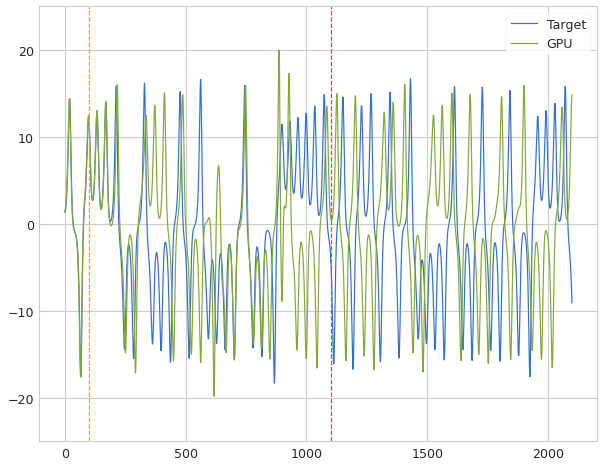

 Iter=148 a=0.865 sr=1.289 amp=1.000  ri=0.084 rr=2.987 loss=0.887886 nrmse=0.238316 CD 0.649569
Iter: 148 #### Time 4.15  NRMSE 0.238 CD 0.650
Iter: 149 #### Time 3.97  NRMSE 1000.000 CD nan
End Run 1 Time 750.716

Best result = 0.8878855886716275
a = 0.8647996372520936
sr = 1.2893430493912903
amp = 0.08395279269758649
ri = 2.98686765390469
********** Size 50 -- Run 4 ***********
Iter: 0 #### Time 4.01  NRMSE 1000.000 CD nan
Iter: 1 #### Time 3.94  NRMSE 5.202 CD 0.857
Dist 1.046504


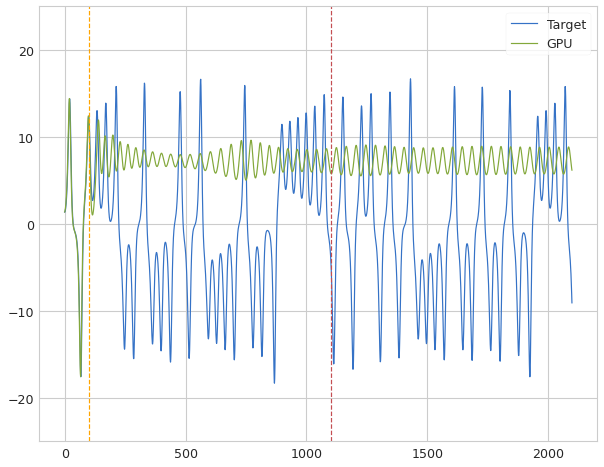

 Iter=2 a=0.615 sr=1.279 amp=1.000  ri=0.020 rr=2.460 loss=1.336687 nrmse=0.290183 CD 1.046504
Iter: 2 #### Time 4.07  NRMSE 0.290 CD 1.047
Dist 1.011717


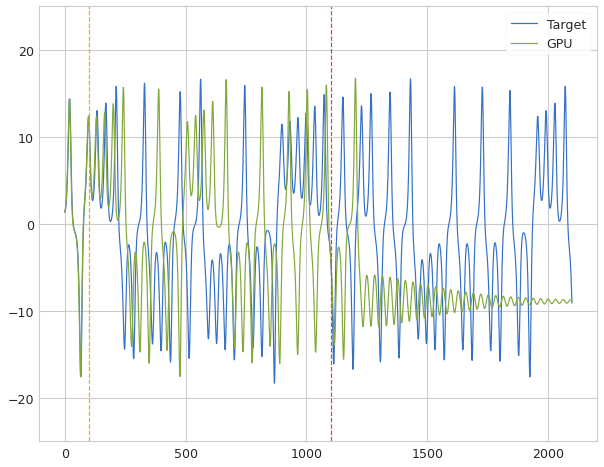

 Iter=3 a=0.540 sr=1.268 amp=1.000  ri=0.047 rr=2.527 loss=1.306756 nrmse=0.295039 CD 1.011717
Iter: 3 #### Time 4.08  NRMSE 0.295 CD 1.012
Iter: 4 #### Time 3.93  NRMSE 0.304 CD 1.060
Iter: 5 #### Time 3.93  NRMSE 1000.000 CD nan
Iter: 6 #### Time 3.94  NRMSE 1000.000 CD nan
Iter: 7 #### Time 3.93  NRMSE 0.319 CD 1.080
Iter: 8 #### Time 3.95  NRMSE 2.863 CD 0.922
Iter: 9 #### Time 3.93  NRMSE 0.311 CD 1.047
Iter: 10 #### Time 3.94  NRMSE 1000.000 CD nan
Iter: 11 #### Time 3.93  NRMSE 1000.000 CD nan
Iter: 12 #### Time 3.94  NRMSE 1.620 CD 1.018
Iter: 13 #### Time 3.95  NRMSE 1.525 CD 0.999
Iter: 14 #### Time 3.94  NRMSE 1000.000 CD nan
Iter: 15 #### Time 3.92  NRMSE 0.309 CD 1.069
Iter: 16 #### Time 3.94  NRMSE 0.541 CD 1.009
Iter: 17 #### Time 3.94  NRMSE 0.498 CD 0.981
Iter: 18 #### Time 3.93  NRMSE 0.494 CD 0.976
Iter: 19 #### Time 3.94  NRMSE 1000.000 CD nan
Iter: 20 #### Time 3.93  NRMSE 0.430 CD 1.040
Dist 0.892725


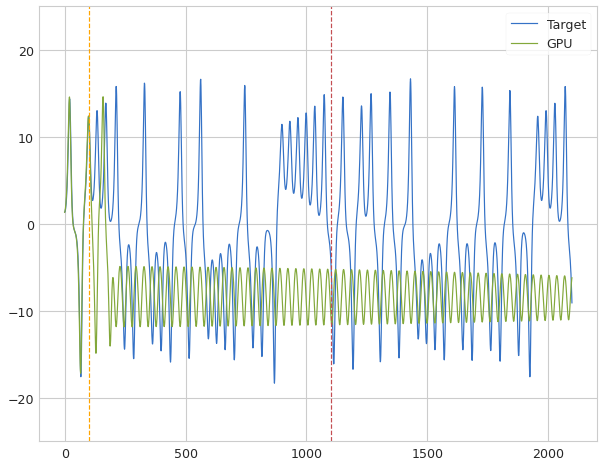

 Iter=21 a=0.578 sr=1.387 amp=1.000  ri=0.096 rr=2.349 loss=1.180621 nrmse=0.287895 CD 0.892725
Iter: 21 #### Time 4.19  NRMSE 0.288 CD 0.893
Iter: 22 #### Time 3.94  NRMSE 1000.000 CD nan
Iter: 23 #### Time 3.93  NRMSE 0.456 CD 0.951
Iter: 24 #### Time 3.92  NRMSE 0.307 CD 1.030
Iter: 25 #### Time 3.93  NRMSE 0.330 CD 1.067
Iter: 26 #### Time 3.93  NRMSE 0.300 CD 1.060
Iter: 27 #### Time 3.93  NRMSE 0.331 CD 1.064
Iter: 28 #### Time 3.93  NRMSE 1000.000 CD nan
Iter: 29 #### Time 3.93  NRMSE 0.308 CD 1.053
Iter: 30 #### Time 3.94  NRMSE 1.551 CD 0.996
Iter: 31 #### Time 3.94  NRMSE 0.402 CD 1.149
Iter: 32 #### Time 3.94  NRMSE 0.319 CD 1.040
Iter: 33 #### Time 3.94  NRMSE 1000.000 CD nan
Iter: 34 #### Time 3.94  NRMSE 0.312 CD 1.043
Iter: 35 #### Time 3.98  NRMSE 1000.000 CD nan
Iter: 36 #### Time 3.94  NRMSE 1.569 CD 0.999
Iter: 37 #### Time 3.94  NRMSE 0.546 CD 0.970
Iter: 38 #### Time 3.94  NRMSE 1000.000 CD nan
Iter: 39 #### Time 3.94  NRMSE 1.013 CD 1.037
Iter: 40 #### Time 3.94  

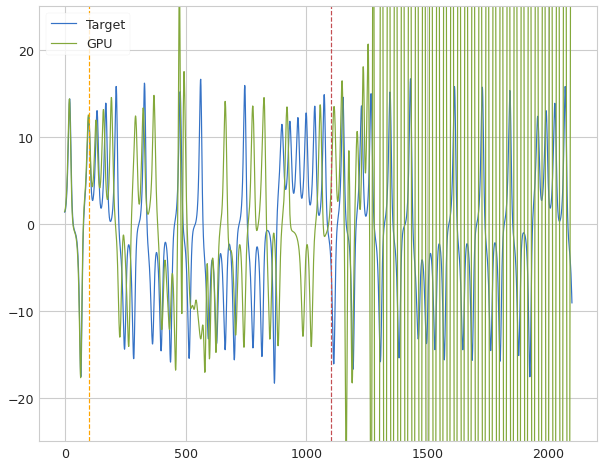

 Iter=51 a=0.739 sr=1.380 amp=1.000  ri=0.069 rr=2.288 loss=1.178349 nrmse=0.285807 CD 0.892542
Iter: 51 #### Time 4.09  NRMSE 0.286 CD 0.893
Iter: 52 #### Time 3.94  NRMSE 0.450 CD 0.947
Iter: 53 #### Time 3.94  NRMSE 0.898 CD 1.027
Iter: 54 #### Time 3.93  NRMSE 0.299 CD 1.048
Dist 0.725066


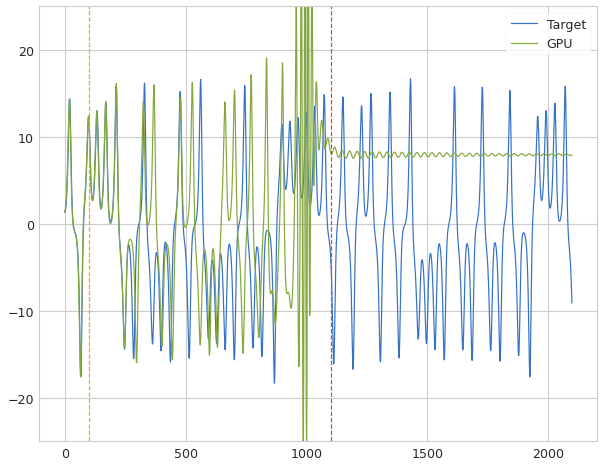

 Iter=55 a=0.600 sr=1.223 amp=1.000  ri=0.024 rr=2.868 loss=1.011576 nrmse=0.286510 CD 0.725066
Iter: 55 #### Time 4.13  NRMSE 0.287 CD 0.725
Iter: 56 #### Time 3.97  NRMSE 1000.000 CD nan
Iter: 57 #### Time 3.95  NRMSE 1000.000 CD nan
Iter: 58 #### Time 3.94  NRMSE 1000.000 CD nan
Iter: 59 #### Time 3.94  NRMSE 1.248 CD 1.147
Iter: 60 #### Time 3.95  NRMSE 0.314 CD 1.060
Iter: 61 #### Time 3.96  NRMSE 0.248 CD 1.134
Iter: 62 #### Time 3.94  NRMSE 1000.000 CD nan
Iter: 63 #### Time 3.99  NRMSE 1000.000 CD nan
Iter: 64 #### Time 3.95  NRMSE 0.315 CD 1.146
Iter: 65 #### Time 3.94  NRMSE 0.393 CD 0.964
Iter: 66 #### Time 3.94  NRMSE 1.126 CD 0.949
Iter: 67 #### Time 3.94  NRMSE 1000.000 CD nan
Iter: 68 #### Time 3.95  NRMSE 1000.000 CD nan
Iter: 69 #### Time 3.94  NRMSE 1000.000 CD nan
Iter: 70 #### Time 3.96  NRMSE 0.393 CD 1.010
Iter: 71 #### Time 3.95  NRMSE 1000.000 CD nan
Iter: 72 #### Time 3.94  NRMSE 0.683 CD 0.955
Iter: 73 #### Time 3.95  NRMSE 1000.000 CD nan
Iter: 74 #### Time 3

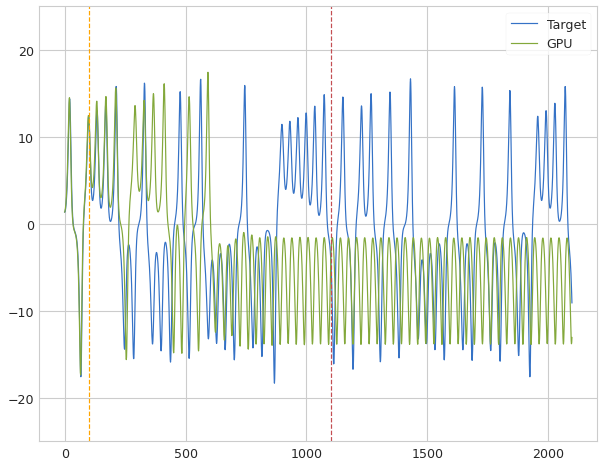

 Iter=17 a=0.591 sr=1.291 amp=1.000  ri=0.029 rr=2.729 loss=1.285381 nrmse=0.294142 CD 0.991239
Iter: 17 #### Time 5.44  NRMSE 0.294 CD 0.991
Iter: 18 #### Time 4.97  NRMSE 0.356 CD 1.067
Iter: 19 #### Time 3.95  NRMSE 1000.000 CD nan
Iter: 20 #### Time 3.99  NRMSE 0.325 CD 1.067
Iter: 21 #### Time 3.96  NRMSE 1.023 CD 0.962
Iter: 22 #### Time 5.19  NRMSE 0.378 CD 1.011
Dist 1.003429


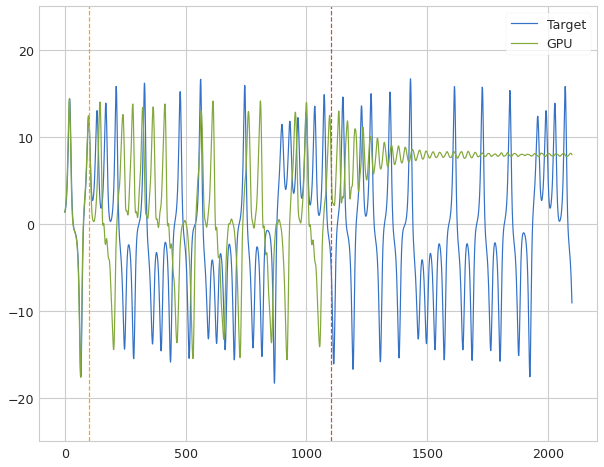

 Iter=23 a=0.579 sr=1.303 amp=1.000  ri=0.005 rr=2.594 loss=1.283666 nrmse=0.280236 CD 1.003429
Iter: 23 #### Time 5.37  NRMSE 0.280 CD 1.003
Iter: 24 #### Time 5.26  NRMSE 0.318 CD 1.067
Iter: 25 #### Time 5.27  NRMSE 0.298 CD 1.110
Iter: 26 #### Time 3.87  NRMSE 0.511 CD 0.962
Iter: 27 #### Time 3.77  NRMSE 0.334 CD 1.069
Dist 0.980137


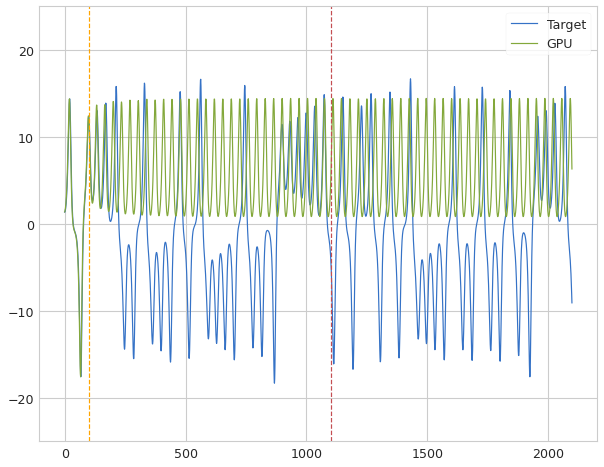

 Iter=28 a=0.622 sr=1.385 amp=1.000  ri=0.076 rr=2.304 loss=1.266877 nrmse=0.286740 CD 0.980137
Iter: 28 #### Time 4.06  NRMSE 0.287 CD 0.980
Iter: 29 #### Time 4.05  NRMSE 0.430 CD 0.995
Iter: 30 #### Time 4.05  NRMSE 0.312 CD 1.031
Iter: 31 #### Time 3.93  NRMSE 0.317 CD 1.128
Iter: 32 #### Time 3.90  NRMSE 0.326 CD 0.906
Iter: 33 #### Time 3.83  NRMSE 1.045 CD 1.007
Iter: 34 #### Time 3.86  NRMSE 0.317 CD 1.059
Iter: 35 #### Time 3.94  NRMSE 0.620 CD 1.024
Iter: 36 #### Time 3.79  NRMSE 1.661 CD 0.985
Iter: 37 #### Time 3.76  NRMSE 0.310 CD 1.057
Iter: 38 #### Time 3.96  NRMSE 1000.000 CD nan
Dist 0.942392


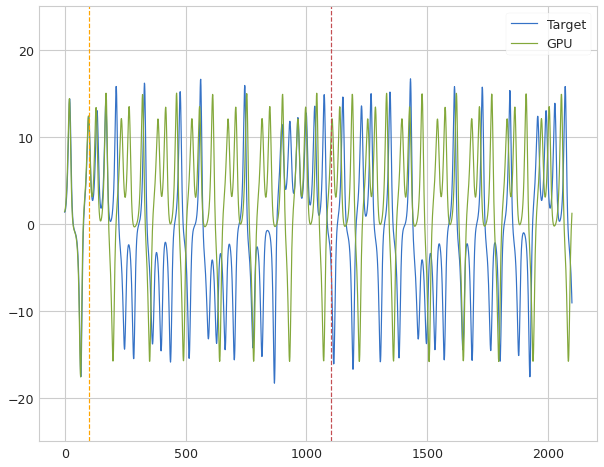

 Iter=39 a=0.607 sr=1.349 amp=1.000  ri=0.069 rr=2.424 loss=1.225079 nrmse=0.282688 CD 0.942392
Iter: 39 #### Time 4.10  NRMSE 0.283 CD 0.942
Iter: 40 #### Time 4.02  NRMSE 0.325 CD 1.061
Dist 0.911681


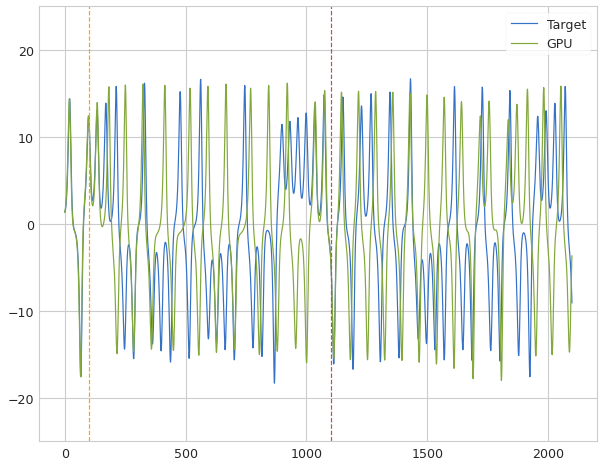

 Iter=41 a=0.587 sr=1.396 amp=1.000  ri=0.061 rr=2.796 loss=1.187241 nrmse=0.275560 CD 0.911681
Iter: 41 #### Time 4.06  NRMSE 0.276 CD 0.912
Iter: 42 #### Time 3.92  NRMSE 5.755 CD 0.899
Iter: 43 #### Time 3.93  NRMSE 1000.000 CD nan
Iter: 44 #### Time 3.92  NRMSE 0.288 CD 0.978
Iter: 45 #### Time 3.92  NRMSE 1000.000 CD nan
Iter: 46 #### Time 3.91  NRMSE 0.402 CD 0.978
Iter: 47 #### Time 3.93  NRMSE 1.000 CD 0.991
Iter: 48 #### Time 3.92  NRMSE 1000.000 CD nan
Iter: 49 #### Time 3.93  NRMSE 1000.000 CD nan
Iter: 50 #### Time 3.93  NRMSE 1000.000 CD nan
Iter: 51 #### Time 3.94  NRMSE 0.380 CD 1.024
Dist 0.729071


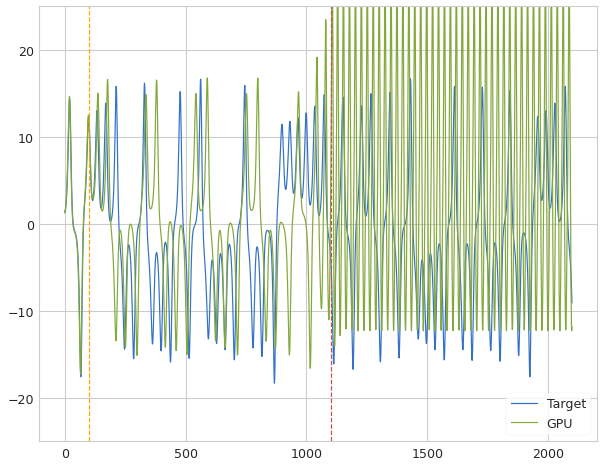

 Iter=52 a=0.668 sr=1.331 amp=1.000  ri=0.082 rr=2.054 loss=0.978292 nrmse=0.249221 CD 0.729071
Iter: 52 #### Time 4.08  NRMSE 0.249 CD 0.729
Iter: 53 #### Time 3.92  NRMSE 1000.000 CD nan
Iter: 54 #### Time 3.94  NRMSE 0.886 CD 0.973
Iter: 55 #### Time 3.93  NRMSE 2.427 CD 0.994
Iter: 56 #### Time 3.93  NRMSE 0.524 CD 0.939
Iter: 57 #### Time 3.93  NRMSE 1000.000 CD nan
Iter: 58 #### Time 3.93  NRMSE 1.345 CD 0.995
Iter: 59 #### Time 3.92  NRMSE 0.300 CD 1.055
Iter: 60 #### Time 3.91  NRMSE 0.327 CD 1.068
Iter: 61 #### Time 3.92  NRMSE 0.287 CD 0.884
Iter: 62 #### Time 3.92  NRMSE 0.267 CD 0.736
Iter: 63 #### Time 3.91  NRMSE 0.307 CD 0.933
Iter: 64 #### Time 3.93  NRMSE 2.950 CD 1.103
Iter: 65 #### Time 3.92  NRMSE 0.743 CD 1.006
Iter: 66 #### Time 3.92  NRMSE 1.070 CD 1.017
Iter: 67 #### Time 3.92  NRMSE 1000.000 CD nan
Iter: 68 #### Time 3.95  NRMSE 0.344 CD 1.086
Iter: 69 #### Time 3.91  NRMSE 5.237 CD 1.126
Iter: 70 #### Time 3.91  NRMSE 0.337 CD 1.067
Iter: 71 #### Time 3.92  NR

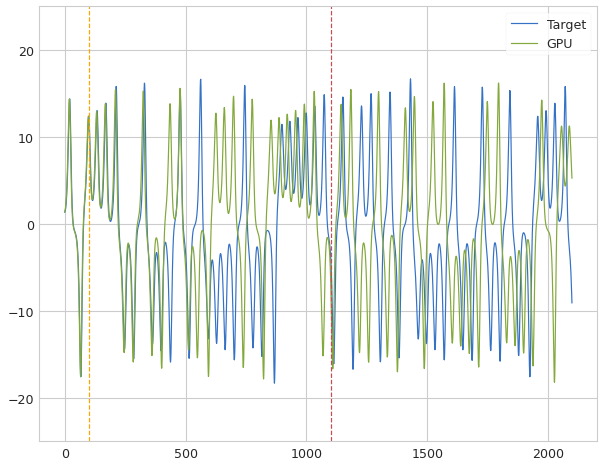

 Iter=0 a=0.556 sr=1.305 amp=1.000  ri=0.076 rr=2.310 loss=0.929500 nrmse=0.242114 CD 0.687386
Iter: 0 #### Time 4.09  NRMSE 0.242 CD 0.687
Iter: 1 #### Time 3.92  NRMSE 0.670 CD 1.076
Iter: 2 #### Time 3.95  NRMSE 0.321 CD 1.047
Iter: 3 #### Time 3.90  NRMSE 0.306 CD 1.026
Iter: 4 #### Time 3.91  NRMSE 1000.000 CD nan
Iter: 5 #### Time 3.90  NRMSE 17.684 CD 1.131
Iter: 6 #### Time 3.91  NRMSE 0.874 CD 1.004
Iter: 7 #### Time 3.92  NRMSE 1.750 CD 0.998
Iter: 8 #### Time 3.91  NRMSE 0.644 CD 0.976
Iter: 9 #### Time 3.91  NRMSE 0.388 CD 0.987
Iter: 10 #### Time 3.91  NRMSE 0.323 CD 1.063
Iter: 11 #### Time 3.90  NRMSE 0.491 CD 1.025
Iter: 12 #### Time 3.91  NRMSE 1000.000 CD nan
Iter: 13 #### Time 3.90  NRMSE 0.288 CD 0.754
Iter: 14 #### Time 3.90  NRMSE 0.305 CD 0.948
Iter: 15 #### Time 3.92  NRMSE 1000.000 CD nan
Iter: 16 #### Time 3.91  NRMSE 0.335 CD 1.065
Iter: 17 #### Time 3.90  NRMSE 1000.000 CD nan
Iter: 18 #### Time 3.94  NRMSE 1000.000 CD nan
Iter: 19 #### Time 3.90  NRMSE 1000

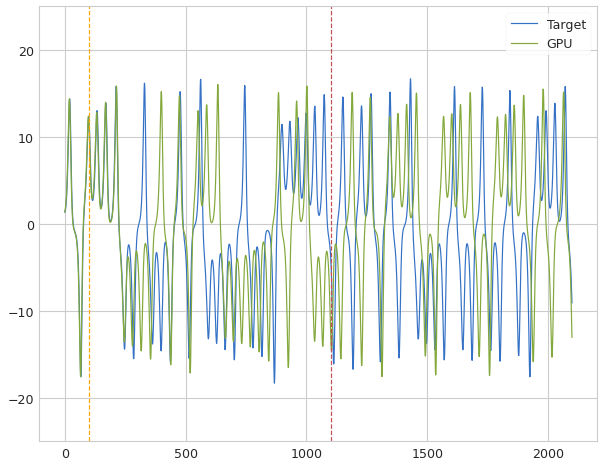

 Iter=91 a=0.673 sr=1.243 amp=1.000  ri=0.089 rr=2.925 loss=0.917888 nrmse=0.242998 CD 0.674890
Iter: 91 #### Time 5.32  NRMSE 0.243 CD 0.675
Iter: 92 #### Time 5.17  NRMSE 0.637 CD 0.974
Iter: 93 #### Time 5.15  NRMSE 0.306 CD 1.048
Iter: 94 #### Time 5.21  NRMSE 0.308 CD 1.046
Iter: 95 #### Time 5.13  NRMSE 1000.000 CD nan
Iter: 96 #### Time 3.96  NRMSE 1000.000 CD nan
Iter: 97 #### Time 3.93  NRMSE 0.319 CD 1.077
Iter: 98 #### Time 4.01  NRMSE 1000.000 CD nan
Iter: 99 #### Time 3.95  NRMSE 0.892 CD 0.993
Iter: 100 #### Time 3.98  NRMSE 2.337 CD 0.999
Iter: 101 #### Time 3.98  NRMSE 0.260 CD 0.711
Iter: 102 #### Time 3.95  NRMSE 0.341 CD 1.087
Iter: 103 #### Time 3.92  NRMSE 155925879965461345060595433472.000 CD 1.000
Iter: 104 #### Time 3.99  NRMSE 1000.000 CD nan
Iter: 105 #### Time 3.92  NRMSE 0.273 CD 0.861
Iter: 106 #### Time 3.91  NRMSE 0.326 CD 1.074
Iter: 107 #### Time 3.93  NRMSE 0.888 CD 0.950
Iter: 108 #### Time 3.92  NRMSE 0.343 CD 1.071
Iter: 109 #### Time 3.93  NRMSE 0.

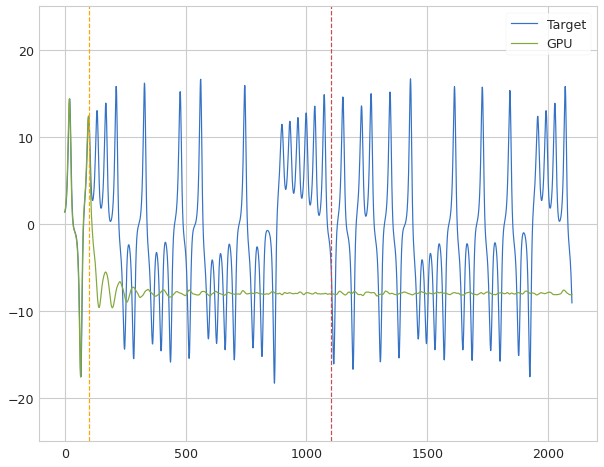

 Iter=9 a=0.815 sr=1.343 amp=1.000  ri=0.003 rr=2.316 loss=1.178919 nrmse=0.278932 CD 0.899987
Iter: 9 #### Time 5.35  NRMSE 0.279 CD 0.900
Iter: 10 #### Time 3.81  NRMSE 0.293 CD 0.996
Iter: 11 #### Time 3.74  NRMSE 0.320 CD 1.062
Iter: 12 #### Time 3.74  NRMSE 0.842 CD 1.012
Iter: 13 #### Time 3.74  NRMSE 0.318 CD 1.063
Iter: 14 #### Time 3.74  NRMSE 0.312 CD 0.939
Iter: 15 #### Time 3.74  NRMSE 3.188 CD 0.995
Iter: 16 #### Time 3.74  NRMSE 0.306 CD 1.051
Iter: 17 #### Time 3.73  NRMSE 0.974 CD 0.993
Iter: 18 #### Time 3.74  NRMSE 1000.000 CD nan
Iter: 19 #### Time 3.75  NRMSE 0.289 CD 0.973
Iter: 20 #### Time 3.77  NRMSE 1000.000 CD nan
Iter: 21 #### Time 3.91  NRMSE 0.300 CD 1.085
Iter: 22 #### Time 3.95  NRMSE 0.305 CD 1.081
Iter: 23 #### Time 3.95  NRMSE 0.346 CD 0.942
Iter: 24 #### Time 3.96  NRMSE 0.283 CD 0.937
Dist 0.746296


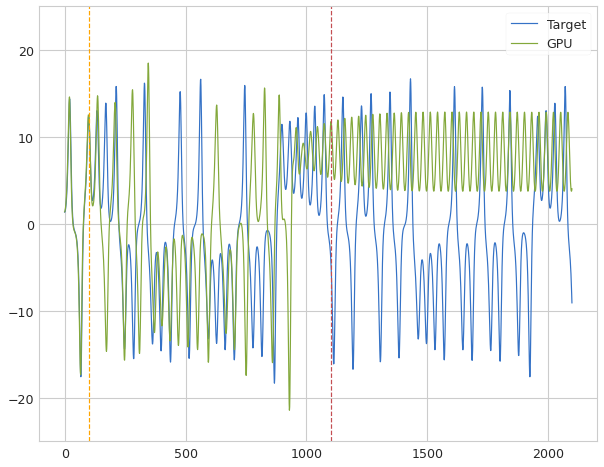

 Iter=25 a=0.593 sr=1.241 amp=1.000  ri=0.096 rr=2.766 loss=1.005035 nrmse=0.258739 CD 0.746296
Iter: 25 #### Time 4.05  NRMSE 0.259 CD 0.746
Iter: 26 #### Time 3.97  NRMSE 0.644 CD 0.896
Iter: 27 #### Time 3.91  NRMSE 0.302 CD 1.062
Iter: 28 #### Time 3.90  NRMSE 0.546 CD 0.932
Iter: 29 #### Time 3.91  NRMSE 1000.000 CD nan
Iter: 30 #### Time 3.85  NRMSE 0.835 CD 0.989
Iter: 31 #### Time 3.79  NRMSE 1000.000 CD nan
Iter: 32 #### Time 3.83  NRMSE 0.269 CD 0.838
Iter: 33 #### Time 3.81  NRMSE 1000.000 CD nan
Iter: 34 #### Time 3.74  NRMSE 1000.000 CD nan
Iter: 35 #### Time 3.80  NRMSE 0.323 CD 1.088
Iter: 36 #### Time 5.07  NRMSE 0.298 CD 0.921
Iter: 37 #### Time 5.27  NRMSE 1000.000 CD nan
Iter: 38 #### Time 5.25  NRMSE 0.697 CD 0.960
Iter: 39 #### Time 5.21  NRMSE 1000.000 CD nan
Iter: 40 #### Time 5.21  NRMSE 1.669 CD 0.987
Iter: 41 #### Time 5.24  NRMSE 0.277 CD 0.995
Iter: 42 #### Time 5.22  NRMSE 3.048 CD 1.098
Iter: 43 #### Time 5.23  NRMSE 0.313 CD 1.057
Iter: 44 #### Time 5.21 

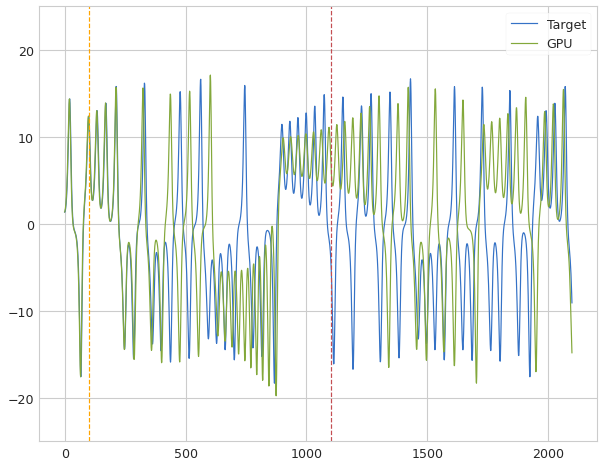

 Iter=49 a=0.860 sr=1.272 amp=1.000  ri=0.089 rr=2.306 loss=0.762478 nrmse=0.224994 CD 0.537484
Iter: 49 #### Time 4.09  NRMSE 0.225 CD 0.537
Iter: 50 #### Time 3.75  NRMSE 0.327 CD 1.061
Iter: 51 #### Time 3.76  NRMSE 1000.000 CD nan
Iter: 52 #### Time 3.79  NRMSE 7.591 CD 1.001
Iter: 53 #### Time 3.92  NRMSE 1000.000 CD nan
Iter: 54 #### Time 3.97  NRMSE 1000.000 CD nan
Iter: 55 #### Time 3.97  NRMSE 0.288 CD 0.959
Iter: 56 #### Time 4.03  NRMSE 21.287 CD 0.924
Iter: 57 #### Time 3.94  NRMSE 0.538 CD 0.897
Iter: 58 #### Time 3.94  NRMSE 0.328 CD 0.939
Iter: 59 #### Time 3.93  NRMSE 1000.000 CD nan
Iter: 60 #### Time 3.92  NRMSE 0.258 CD 0.766
Iter: 61 #### Time 3.93  NRMSE 0.300 CD 1.055
Iter: 62 #### Time 3.92  NRMSE 1000.000 CD nan
Iter: 63 #### Time 3.91  NRMSE 0.275 CD 0.804
Iter: 64 #### Time 3.91  NRMSE 0.301 CD 1.093
Iter: 65 #### Time 3.91  NRMSE 0.325 CD 1.198
Iter: 66 #### Time 3.92  NRMSE 0.685 CD 1.212
Iter: 67 #### Time 3.91  NRMSE 1000.000 CD nan
Iter: 68 #### Time 3.92

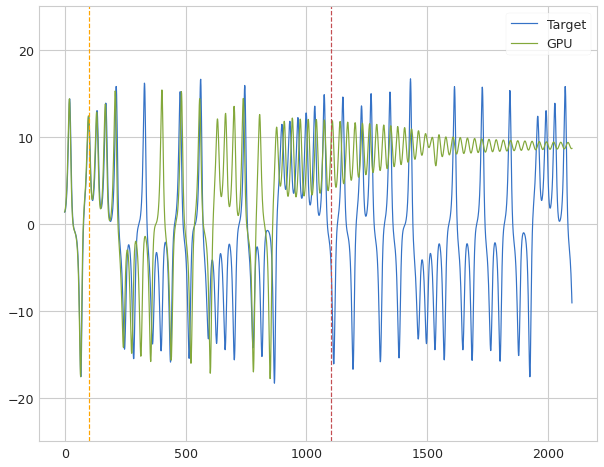

 Iter=3 a=0.661 sr=1.380 amp=1.000  ri=0.074 rr=2.275 loss=0.803895 nrmse=0.223133 CD 0.580762
Iter: 3 #### Time 4.07  NRMSE 0.223 CD 0.581
Iter: 4 #### Time 3.91  NRMSE 1000.000 CD nan
Iter: 5 #### Time 3.93  NRMSE 65.376 CD 1.142
Iter: 6 #### Time 3.91  NRMSE 0.322 CD 1.068
Iter: 7 #### Time 3.92  NRMSE 13.211 CD 0.997
Iter: 8 #### Time 3.93  NRMSE 2.089 CD 0.990
Iter: 9 #### Time 3.91  NRMSE 1.273 CD 1.117
Iter: 10 #### Time 3.92  NRMSE 0.364 CD 1.428
Iter: 11 #### Time 3.91  NRMSE 0.342 CD 1.125
Iter: 12 #### Time 3.92  NRMSE 1000.000 CD nan
Iter: 13 #### Time 3.92  NRMSE 1000.000 CD nan
Iter: 14 #### Time 3.91  NRMSE 0.401 CD 1.045
Iter: 15 #### Time 3.92  NRMSE 1000.000 CD nan
Iter: 16 #### Time 3.92  NRMSE 0.377 CD 1.073
Iter: 17 #### Time 3.94  NRMSE 0.277 CD 0.874
Iter: 18 #### Time 3.92  NRMSE 0.321 CD 1.065
Iter: 19 #### Time 3.91  NRMSE 1000.000 CD nan
Iter: 20 #### Time 3.91  NRMSE 0.511 CD 0.890
Iter: 21 #### Time 3.92  NRMSE 1000.000 CD nan
Iter: 22 #### Time 3.92  NRMSE

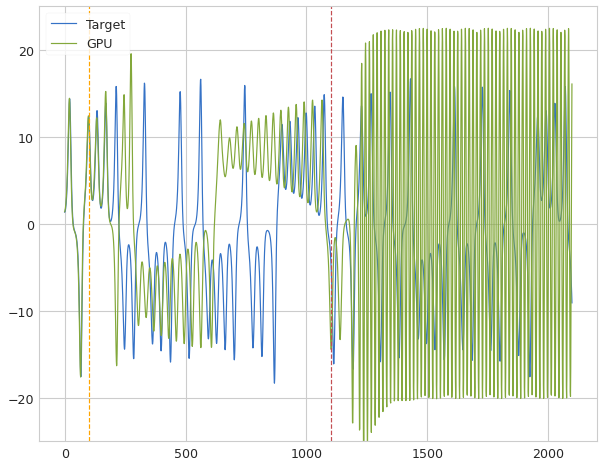

 Iter=7 a=0.528 sr=1.268 amp=1.000  ri=0.092 rr=2.247 loss=1.205229 nrmse=0.288436 CD 0.916794
Iter: 7 #### Time 4.11  NRMSE 0.288 CD 0.917
Iter: 8 #### Time 3.95  NRMSE 0.337 CD 1.065
Dist 0.779107


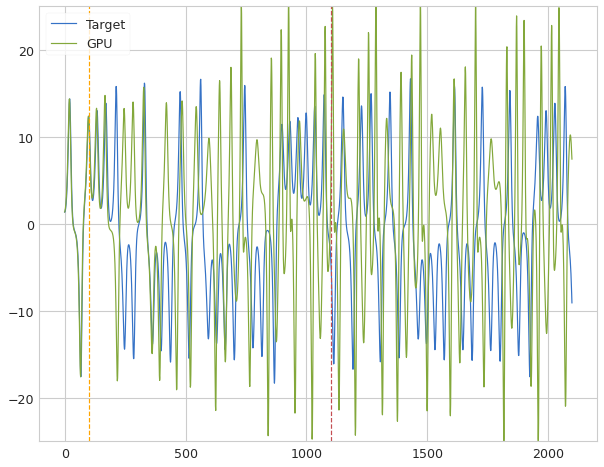

 Iter=9 a=0.597 sr=1.362 amp=1.000  ri=0.097 rr=2.798 loss=1.059772 nrmse=0.280665 CD 0.779107
Iter: 9 #### Time 4.10  NRMSE 0.281 CD 0.779
Iter: 10 #### Time 3.95  NRMSE 0.277 CD 0.868
Iter: 11 #### Time 3.90  NRMSE 1000.000 CD nan
Iter: 12 #### Time 3.92  NRMSE 0.398 CD 1.054
Iter: 13 #### Time 3.91  NRMSE 0.301 CD 1.007
Iter: 14 #### Time 3.92  NRMSE 0.676 CD 0.875
Iter: 15 #### Time 3.89  NRMSE 0.494 CD 0.891
Iter: 16 #### Time 3.93  NRMSE 1.030 CD 1.005
Iter: 17 #### Time 3.93  NRMSE 1.659 CD 1.005
Iter: 18 #### Time 3.90  NRMSE 0.362 CD 0.978
Iter: 19 #### Time 3.94  NRMSE 1000.000 CD nan
Iter: 20 #### Time 3.93  NRMSE 0.305 CD 0.896
Iter: 21 #### Time 3.90  NRMSE 0.341 CD 1.353
Iter: 22 #### Time 3.90  NRMSE 1000.000 CD nan
Iter: 23 #### Time 3.90  NRMSE 0.271 CD 0.825
Iter: 24 #### Time 3.89  NRMSE 0.338 CD 1.142
Iter: 25 #### Time 3.89  NRMSE 0.296 CD 0.961
Iter: 26 #### Time 3.90  NRMSE 10.395 CD 1.002
Iter: 27 #### Time 3.96  NRMSE 0.375 CD 0.976
Iter: 28 #### Time 3.90  NRM

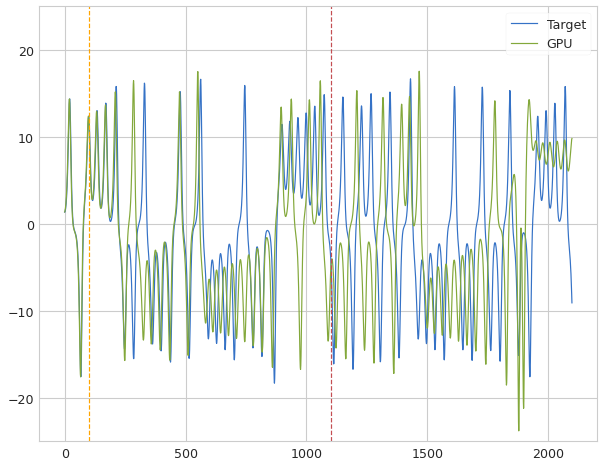

 Iter=86 a=0.568 sr=1.388 amp=1.000  ri=0.078 rr=2.509 loss=0.695450 nrmse=0.208351 CD 0.487098
Iter: 86 #### Time 5.07  NRMSE 0.208 CD 0.487
Iter: 87 #### Time 3.96  NRMSE 1000.000 CD nan
Iter: 88 #### Time 3.96  NRMSE 1000.000 CD nan
Iter: 89 #### Time 3.89  NRMSE 0.752 CD 1.120
Iter: 90 #### Time 3.90  NRMSE 1000.000 CD nan
Iter: 91 #### Time 3.90  NRMSE 0.240 CD 0.667
Iter: 92 #### Time 3.88  NRMSE 4.344 CD 1.142
Iter: 93 #### Time 3.91  NRMSE 0.323 CD 1.058
Iter: 94 #### Time 3.91  NRMSE 0.259 CD 0.807
Iter: 95 #### Time 3.91  NRMSE 1.550 CD 0.989
Iter: 96 #### Time 3.93  NRMSE 1000.000 CD nan
Iter: 97 #### Time 3.90  NRMSE 1000.000 CD nan
Iter: 98 #### Time 3.91  NRMSE 0.355 CD 0.725
Iter: 99 #### Time 3.91  NRMSE 0.321 CD 1.064
Iter: 100 #### Time 3.89  NRMSE 0.315 CD 1.056
Iter: 101 #### Time 3.90  NRMSE 0.927 CD 0.995
Iter: 102 #### Time 3.89  NRMSE 0.291 CD 0.992
Iter: 103 #### Time 3.90  NRMSE 1000.000 CD nan
Iter: 104 #### Time 3.88  NRMSE 0.549 CD 0.989
Iter: 105 #### Time

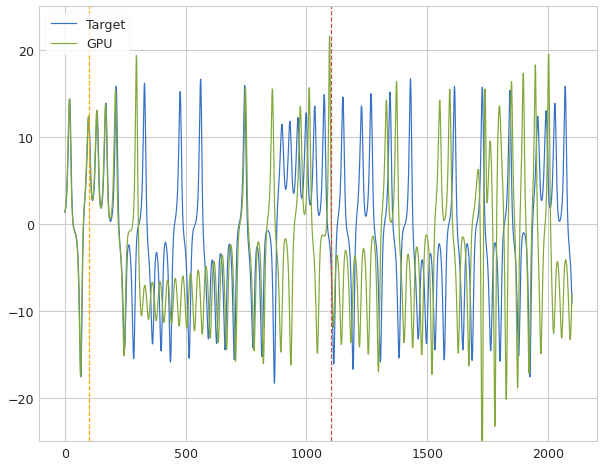

 Iter=6 a=0.846 sr=1.231 amp=1.000  ri=0.078 rr=2.483 loss=0.887538 nrmse=0.242472 CD 0.645066
Iter: 6 #### Time 4.22  NRMSE 0.242 CD 0.645
Iter: 7 #### Time 4.04  NRMSE 0.312 CD 1.062
Iter: 8 #### Time 4.04  NRMSE 0.357 CD 0.984
Iter: 9 #### Time 3.94  NRMSE 2.139 CD 0.998
Iter: 10 #### Time 4.00  NRMSE 0.277 CD 0.860
Iter: 11 #### Time 3.96  NRMSE 1000.000 CD nan
Iter: 12 #### Time 3.97  NRMSE 0.272 CD 0.863
Iter: 13 #### Time 4.01  NRMSE 0.292 CD 0.996
Iter: 14 #### Time 3.99  NRMSE 1.995 CD 0.893
Iter: 15 #### Time 3.99  NRMSE 0.269 CD 0.846
Iter: 16 #### Time 3.97  NRMSE 0.679 CD 1.064
Iter: 17 #### Time 4.04  NRMSE 1000.000 CD nan
Iter: 18 #### Time 4.04  NRMSE 0.424 CD 0.969
Iter: 19 #### Time 3.97  NRMSE 0.374 CD 1.056
Iter: 20 #### Time 3.98  NRMSE 0.278 CD 0.881
Iter: 21 #### Time 3.97  NRMSE 0.269 CD 0.845
Iter: 22 #### Time 3.97  NRMSE 1.192 CD 1.129
Iter: 23 #### Time 3.95  NRMSE 0.299 CD 1.037
Iter: 24 #### Time 3.94  NRMSE 0.272 CD 0.852
Iter: 25 #### Time 3.97  NRMSE 0.

In [ ]:
CALLS = 150
s = torch.torch.from_numpy(signal).cuda(DEVICE).type(dtype)
# Skipped 1000, 900
size = [50,40,30,20,10]
rand_state = [11,37,3,24,91]

dict_counters = {}
dict_model = {}
for N in size:
    model_counter = 0
    error_per_N = []
    best_N_model = [N,0,0,0]
    
    min_a, max_a = .5, .9
    min_sr, max_sr = 1.2, 1.4
    min_g, max_g = .4, 1.1
    min_ri, max_ri = .001, .1
    min_rr, max_rr = 2, 3
    space = [Real(min_a, max_a, name='a'),
             Real(min_sr, max_sr, name='sr'),
             Real(min_ri, max_ri, name='ri'),
             Real(min_rr, max_rr, name='rr')
            ]
    error_over_N = 1000
    for ref in range(5):
        
        alphas = []
        rhos = []
        gammas = []
        inScales = []
        resScales = []
        
        for rn in range(5):
            start = time.time()
            running_error = 1000
            counter = 0 
            print(f'********** Size {N} -- Run {rn} ***********')
            result_gp = gp_minimize(loop,
                                    space,
                                    n_calls=CALLS,
                                    random_state=rand_state[rn],
                                    n_jobs=4,
                                    n_initial_points=100)
            end = time.time()-start
            print(f'End Run {ref} Time {end:.3f}')
            print(f'\nBest result = {result_gp.fun}')
            names = ['a','sr','amp','ri','rr']
            for i in range(len(space)):
                print(f'{names[i]} = {result_gp.x[i]}')
                
        min_a, max_a   = resize_spaces(min_a, max_a,
                                       np.array(alphas),
                                       isAlpha=True)
        min_sr, max_sr = resize_spaces(min_sr, max_sr, np.array(rhos))
        min_g, max_g   = resize_spaces(min_g, max_g, np.array(gammas))
        min_ri, max_ri = resize_spaces(min_ri, max_ri, np.array(inScales))
        min_rr, max_rr = resize_spaces(min_rr, max_rr, np.array(resScales))
        print('Refined search bounds:\n')
        print(f'Alpha ({min_a}, {max_a})\n')
        print(f'Rho ({min_sr}, {max_sr})\n')
        print(f'Gamma ({min_g}, {max_g})\n')
        print(f'r-in ({min_ri}, {max_ri})\n')
        print(f'r-res ({min_rr}, {max_rr})\n')
        end = time.time()-start
        print(f'End Refinement Run {ref} Time {end:.3f}')
        
    print(model_counter)
    dict_counters[str(N)] = {'numModels': model_counter,
                             'meanError': np.mean(np.array(error_per_N)).tolist(),
                             'varError' : np.var(np.array(error_per_N)).tolist()}
    with open('Dicts/diag_Lx50.json', 'w') as fp:
        json.dump(dict_counters, fp, cls=NumpyArrayEncoder)
    with open('Dicts/models_Lx50.json', 'w') as fp:
        json.dump(dict_model, fp, cls=NumpyArrayEncoder)
print(dict_counters)



In [ ]:
fpath = 'Dicts/diag_Lx50.json'
with open(fpath,'r') as j:
    dict_diag = json.loads(j.read())

fpath = 'Dicts/models_Lx50.json'
with open(fpath,'r') as j:
    dict_models = json.loads(j.read())

In [ ]:
size = [50,40,30,20,10]
plt.figure(figsize=(15,8))
plt.plot(signal[TRAINLENGTH:TRAINLENGTH + TEST], color='g', label='target')
for n in [300]:
    preds = dict_models[str(n)]['Preds']
    error_testset = rca.NRMSE(signal[TRAINLENGTH:TRAINLENGTH + TEST],
                              preds[TRAINLENGTH:TRAINLENGTH + TEST],
                              MINMAX)
    kl,_,_,_ = rca.distribution(signal[TRAINLENGTH:TRAINLENGTH + TEST],
                                preds[TRAINLENGTH:TRAINLENGTH + TEST],
                                 np.min(signal[:TRAINLENGTH+TEST]),
                                 np.max(signal[:TRAINLENGTH+TEST]),
                                 bins=50)
    print(f'N={n}   Error = {error_testset:3f} Div = {kl:.3f}')
    plt.plot(preds[TRAINLENGTH:TRAINLENGTH + TEST],
             linestyle='dotted', label=f'preds{n}')
plt.legend()
plt.show()